# **MRI Tumor Detection with ResNet50 and DinoV2**

In [50]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import torch
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Warnings
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

## **1: Business & Data Understanding**

### **1.1: Dataset Overview**

The "Brain Tumor MRI Dataset" on <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Kaggle</a> provides a comprehensive collection of human brain MRI images aimed at supporting the accurate detection and classification of brain tumors. Consisting of 7,023 images from three distinct datasets - figshare, SARTAJ, and Br35H - this dataset separates MRI scans of brains into four categories: `glioma`, `meningioma`, `no tumor`, and `pituitary`. The dataset has seen several changes according to the description on Kaggle, with some `glioma` images from the SARTAJ dataset being replaced due to inaccuracies, highlighting ongoing modifications being made to the dataset for improved reliability and data quality. With images from the Br35H dataset constituting the `no tumor` class, users should be mindful that the images in this dataset come in varied sizes, meaning that pre-processing and re-sizing must be employed for us to achieve consistent analysis and improved model accuracy.

### **1.2: Purpose of Data Collection**

Brain tumors as a whole pose severe risks given the confined space of the skull, whether or not they are <a href="https://www.cedars-sinai.org/blog/diagnosed-with-benign-tumor.html">malignant or benign</a>. Growth of these tumors can potentially lead to brain damage and life-threatening situations. Timely detection and precise classification of these tumors are absolutely essential in guiding pre-emptive medical diagnosis before tumors signifcantly effect and harm a patient. With MRI's being a predominant imaging technique in this realm, there is a pressing need for advanced diagnostic models that can detect, classify by type, and pinpoint tumor locations effectively. This dataset, assembled from various sources and continuously refined, aims to provide a rich resource for researchers and data scientists to develop advanced machine learning models to aid in these critical diagnostic tasks.

### **1.3: Prediction Task & Stakeholder Interest**

This MRI dataset from Kaggle has been created with the specific intention to facilitate the development of models capable of detecting the presence of a brain tumor from MRI scans and classifying them by type. Medical practitioners and technicians can then use them as an advisory tool to make more precise diagnoses, leading to more targeted treatment options. Accurate labels are extremely important. It's crucial to acknowledge potential inaccuracies, such as those noted in the SARTAJ dataset, ensuring that machine learning models are trained on the most reliable data available.

### **1.4: Algorithm Performance Expectation for Medical Efficacy**

For a machine learning approach in the domain of medical diagnosis to be clinically valuable, the algorithm must excel in capturing intricate details, variations, and nuances from MRI images. Given the collection of data from multiple sources in this Kaggle dataset, a successful algorithm should be adaptable, handling diverse imaging techniques and varying image sizes efficiently. Specifically, it should excel in tasks like tumor detection and type classification, ideally performing better than current diagnostic thresholds in accuracy and reliability. Furthermore, the emphasis on pre-processing, such as resizing images for uniformity, underscores the need for meticulous data preparation to enhance the model's performance. Ultimately, an ideal algorithm would bolster the confidence of medical practitioners in their diagnostic decisions, ensuring timely and effective interventions for patients.

Additionally, the tumor labels should ideally not come from initial diagnoses made by medical practitioners. Instead, the tumor label should be derived a considerable time after the MRI scan to ensure that we capture the ground truth about the existence and type of tumor for a patient, instead of preliminary assessments or biases. Using preliminary data would capture medical biases and cause the trained model to capture the exact same biases as a result. This delayed-labeling approach ensures the training data for machine learning models is as close to the eventual outcome as possible, enhancing the model's predictive accuracy and establishing value that can support medical practitioners and doctors in labeling true diagnoses.

## **2: Data Preparation**

### **2.1: Data Preprocessing Steps**

#### **2.1.1: Dataset Directory Structure**

The Kaggle brain MRI dataset is structured in distinct training and testing folders. 

#### **2.1.2: Image Dimensions Standardization**

All MRI images are likely varying in size, with some images being much larger than others and some images potentially being stretched in ways that could not be interpreted in a standard way by Principal Component Analysis, a Convolutional Neural Network, or a transformer. We will standardize image size by stretching and/or squeezing images to fit into a $256 \times 256$ pixel dimension. This is a crucial preprocessing step. Neural networks, especially convolutional ones, require a consistent input size. Resizing all images to a uniform shape ensures that the network receives inputs in a consistent format, allowing us to batch process the data. Furthermore, downsizing larger images can also speed up the training process, as smaller images generally require less computational resources. On the other hand, recognizable features can be rendered from larger MRI screens with high dimensions could maybe lost from compression, but we are preferring interpretability in this scenario.

Because the images we are observing are MRI scans, we will read in the data and ensure that the images are grayscaled. MRI scans represent variations in tissue properties, not colors as in everyday images. Hence, we read in the data ensuring the images are in grayscale. Grayscaling, in this context, isn't about removing color; instead, it's about representing the MRI scans in a format that aligns with their natural presentation. By using grayscale, we utilize a single channel of floating point values, as opposed to the three channels (RGB) found in colored images. This not only aligns with the nature of MRI scans but also reduces the memory requirement to represent these images by one-third, making processing more efficient.

We will normalize the floating point representation of each grayscaled pixel value by dividing pixel values by 255. This scales all pixel values between 0 and 1. Normalization is an important step in image processing for neural networks, because networks tend to converge faster with normalized inputs. By keeping pixel values within a small range, it ensures that no particular set of weights gets updated disproportionately during the backpropagation process when fine-tuning or training a neural network.

Finally, each 2D image should be reshaped into a 1D array. This transformation is particularly useful when PCA and neural network processing expect a flat array of features for each data point.

### **2.2: Data Preprocessing Implementation**

Below is the implementation for the description of preprocessing steps listed in section 2.1. 

In [2]:
# Load Train / Test Data
train_data_mri: str = 'Dataset/Training/'
test_data_mri: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(test_data_mri + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
train_paths = np.array(train_paths)
train_labels: np.ndarray = np.array(train_labels)
test_paths: np.ndarray = np.array(test_paths)
test_labels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
train_paths = train_paths.reshape(train_paths.shape[0], -1)
test_paths = test_paths.reshape(test_paths.shape[0], -1)

### **2.3: Total Training and Testing Images**

In [80]:
print(f"Total training data MRI scans: {len(train_paths)}.")
print(f"Total testing data MRI scans:  {len(test_paths) }.")

Total training data MRI scans: 5712
Total testing data MRI scans:  1311


Ideally, having more images to train on would be preferrable, but 5,712 MRI scans spanning across multiple data sources is strong nonetheless. Diving deeper, let's check the total appearances for each class in the training data. 

In [87]:
# Find indices for each label
train_indices_0: List[int] = np.where(np.array(train_labels) == 0)[0]
train_indices_1: List[int] = np.where(np.array(train_labels) == 1)[0]
train_indices_2: List[int] = np.where(np.array(train_labels) == 2)[0]
train_indices_3: List[int] = np.where(np.array(train_labels) == 3)[0]

# Total class distributions
print(f"Glioma training data MRI scans: {len(train_indices_0)}.")
print(f"Meningioma training data MRI scans: {len(train_indices_1)}.")
print(f"No Tumor training data MRI scans: {len(train_indices_2)}.")
print(f"Pituitary training data MRI scans: {len(train_indices_3)}.")
print("Total MRI scans with a tumor: {}.".format(
    len(train_indices_0) + len(train_indices_1) + len(train_indices_3)
))

Glioma training data MRI scans: 1321.
Meningioma training data MRI scans: 1339.
No Tumor training data MRI scans: 1595.
Pituitary training data MRI scans: 1457.
Total MRI scans with a tumor: 4117.


The MRI scans labeled as "no tumor" form a significant portion when compared to individual tumor classes. However, overall, the classes are relatively well-balanced. If our goal is to classify the specific type of tumor, this even distribution is advantageous, as it minimizes the risk of the model being overly biased towards a particular class.

On the other hand, if the objective shifts to merely detecting the presence or absence of a tumor, there's a potential pitfall. Out of the 5,712 images, 4,117 showcase some form of tumor. In such a scenario, a binary classification model might be more inclined to predict the presence of a tumor, given that it represents the majority of the dataset. This could lead to the model being overly optimistic about tumor existence. This is actually not terrible problem to have, as a model that overly predicts the existence of a tumor is much stronger than a model that does the opposite. The reason why is because the implications for a false positive for predicting the existence of a tumor is much less costly then a false negative where the model misses a tumor.

### **2.4: Visualizing Content in the Dataset**

#### **2.4.1: Displaying Some Training Images**

In the plot below, we display some images from the training folder provided by Kaggle. The first 10 images with a label 0 represent a glioma tumor, the next 10 images with a label 1 represent a meningioma tumor, then the 10 after that with the label 2 represent a lack of existence of a tumor, and the last 10 images with the label 3 represent pituitary tumors. 

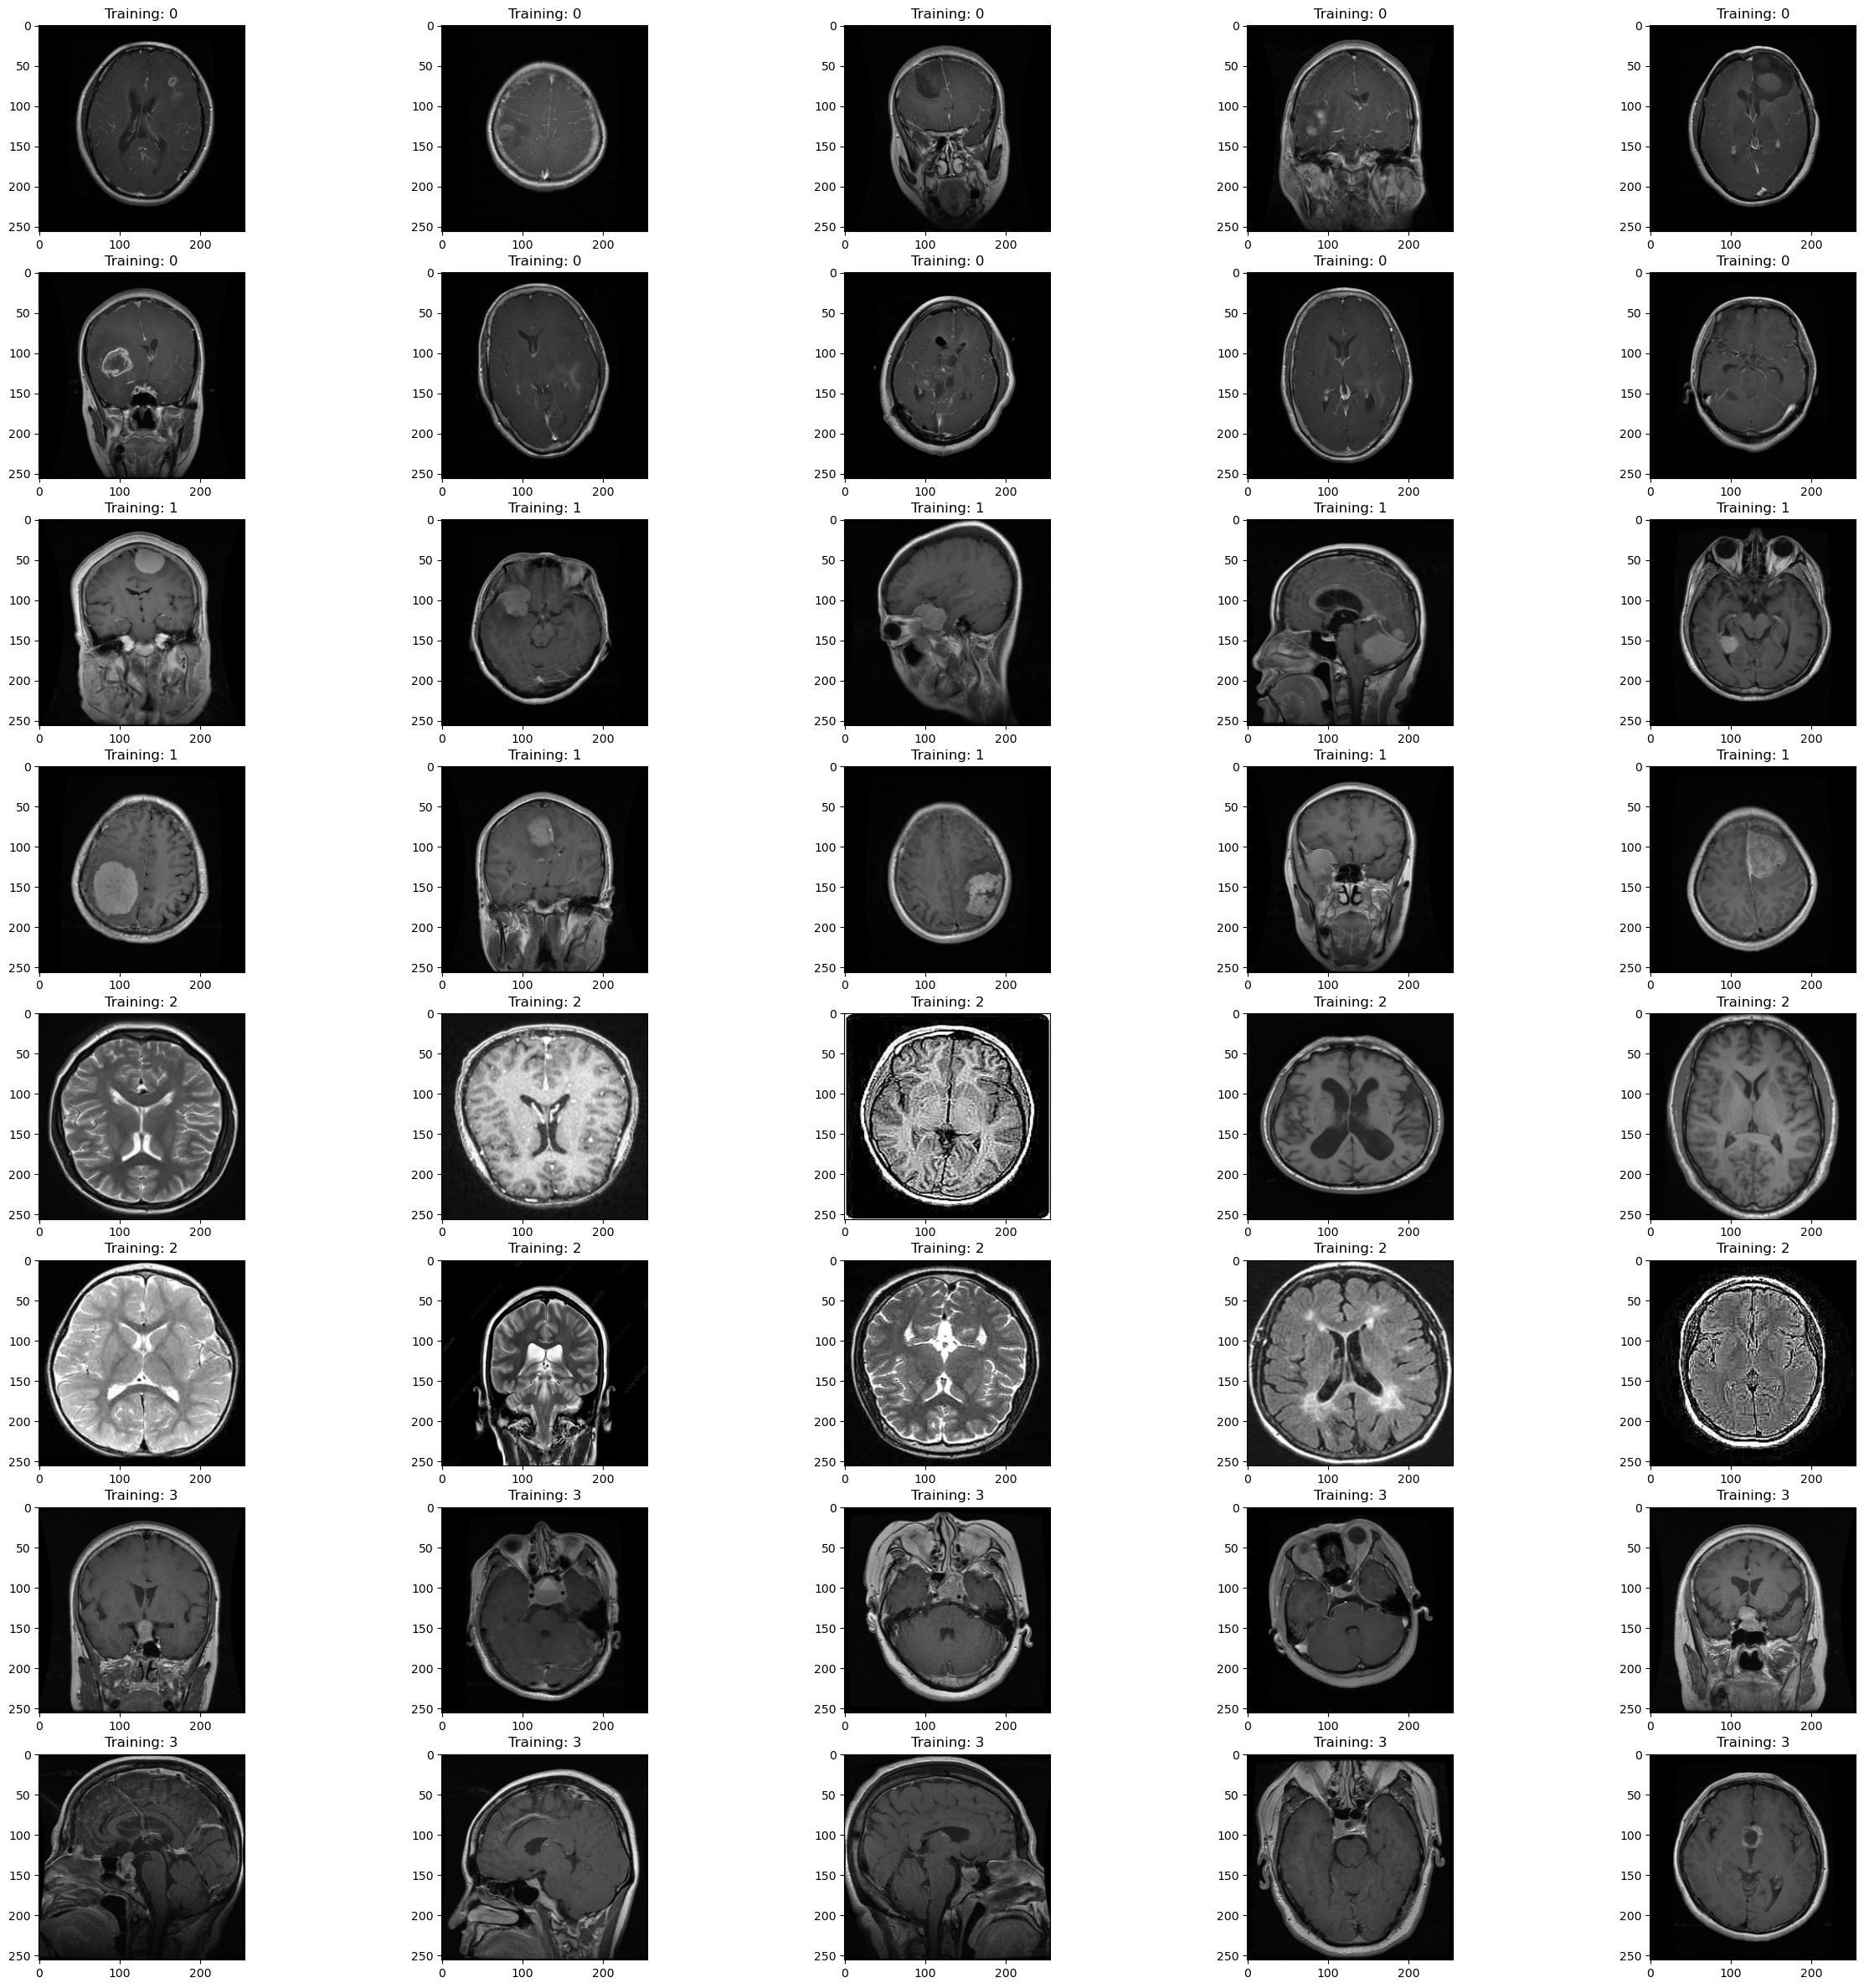

In [84]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Randomly select 10 indices from each set
train_random_indices_0: List[int] = np.random.choice(train_indices_0, 10, replace=False)
train_random_indices_1: List[int] = np.random.choice(train_indices_1, 10, replace=False)
train_random_indices_2: List[int] = np.random.choice(train_indices_2, 10, replace=False)
train_random_indices_3: List[int] = np.random.choice(train_indices_3, 10, replace=False)

train_plot_indices: List[int] = np.concatenate([
    train_random_indices_0, 
    train_random_indices_1, 
    train_random_indices_2, 
    train_random_indices_3,
])

# Ensure indices are unique and within bounds
train_plot_indices = list(set(train_plot_indices))
train_plot_indices.sort()

for index, (image, label) in enumerate(zip(train_paths[train_plot_indices], train_labels[train_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')
    
plt.show()

#### **2.4.2: Identifying MRI Scan Angling**

MRI scans in this Kaggle dataset are all ideally taken from <a href="https://faculty.washington.edu/chudler/slice.html">coronal, sagittal, and horizontal views</a>—in geomertric terms, this means that MRI scans are ideally taken in angles orthogonal to the $xy$, $yz$, or $xz$ planes intersecting a person's face. These angles are standard and seem to largely be what a model we have would be trained on based on the visualization above. However, there is a chance that some of the scans are taken from an <a href="https://www.mr-tip.com/serv1.php?type=db1&dbs=Oblique#:~:text=News%20(%201%20)-,Oblique,axis%20views%20of%20the%20heart.">oblique view</a>, meaning that scans are taken from non-orthogonal angles and showcase a less standard and less clear view of a patient's brain. These scans can likely be the result of a patient flinching and moving before the images are taken. The middle image in the third row of the graph above could maybe be one of these oblique scans for example, because while the scan is clearly an attempt at getting a saggital view of a patient's brain in the MRI scan, the jaw of the patient cannot be clearly defined, suggesting that the patient's head might be twisted in some way where could not capture the jaw as easily as seen in other sagittal scans. 

Ideally in a model, depending on the model we are using, we would consider removing the scans taken from oblique views, because we would not want the training or fine-tuning of our model to be influenced by non-standard angles. While certain models excel in accommodating for variations in angles that pictures are taken, it's generally considered best practice to maintain consistency in the training data. Including a label indicating the scan's direction would be beneficial, allowing us to one-hot-encode this information and feed it as an additional parameter to the model. Possessing such data provides flexibility; we can experiment with including and excluding the type of MRI scans taken in the training process, ensuring we're making informed decisions. It's always more advantageous to have this data and evaluate its relevance, rather than lacking it as a whole.

#### **2.4.3: Honing in on T1 vs. T2 Imaging Discrepency**

MRI's primarily utilize two primary sequences: <a href="https://case.edu/med/neurology/NR/MRI%20Basics.htm">T1-weighted and T2-weighted imaging</a>. These sequences differentiate based on the relaxation times of the tissue being imaged. T1 and T2 relaxation times are measures of how the atomic nuclei within our body's tissues revert to their natural state after being disturbed by a magnetic pulse. T1-weighted images are generated using short TE (Echo Time) and TR (Repetition Time), and the image contrast predominantly hinges on the T1 properties of the tissue. On the flip side, T2-weighted images utilize longer TE and TR times, deriving image contrast mainly from the T2 properties of tissue. A hallmark distinction between these two is how cerebrospinal fluid (CSF) appears: it's **dark in T1-weighted imaging** and **bright in T2-weighted imaging** (assistance in finding T1 and T2 information was also found and corrected through ChatGPT, then we validated it with the source linked above from Case Western).

Observing the MRI scans in the dataset, it's noticeable that no-tumor scans predominantly exhibit a more "white" appearance resembling T2-weighted imaging, meanwhile scans labeled as having tumors lean towards more of a "gray" appearance resembling T1-weighted imaging. The disparity could lead to an unintended bias. This color difference could easily be mis-interpreted as a direct correlation to the presence or absence of tumors. The variation in tone in reality is a product of whether T1 or T2 imaging was employed, instead of being a feature of the tumor presence. This observation raises a critical point: the machine and the method of MRI imaging can influence the output image's appearance. Differentiating between the presence of a tumor should ideally not be contingent on the MRI type. If, for example, all no-tumor scans were predominantly T1 and the tumor scans were T2, our model might be largely basing its decisions on the imaging type rather than the actual presence or nature of the tumor. Such a situation could also indicate that images of distinct categories might have been sourced from specific hospitals or radiologists with a consistent preference for a certain MRI type.

An extra aspect to consider about MRI's of brains with no tumors is that in the Kaggle dataset, these images all are derived from the Br35H dataset, whereas the other MRI scans representing different types of brain tumors all come from different data sources that all ended up compiled together into this Kaggle dataset we are observing now. The authors of this Kaggle dataset did a great job at ensuring that a variety of MRI screening datasets were represented in this sample, but the large T2-weighted imaging bias for predicting lack of tumor based on imaging type may provide us with a false sense of confidence in our models later on when we start our prediction tasks. 

Typically, in a clinical setting, radiologists would provide comprehensive reports accompanying MRI scans. These reports would denote whether T1 or T2 imaging was used, amongst other critical information. However, the Kaggle dataset appears to be stripped of these essential descriptors. Such limitations underline the importance of holistic data for more robust and accurate model training. Without comprehensive metadata, models risk making decisions based on unintended biases rather than genuine features of interest.

To counteract this potential bias, assessing our model's proficiency in distinguishing between glioma, meningioma, and pituitary tumors could provide some insight into its general performance. By focusing on these specific classifications, we can evaluate the model's true distinctive power on MRI scans based on tumors rather than imaging techniques.

#### **2.4.4: Visualizing the Testing Data**

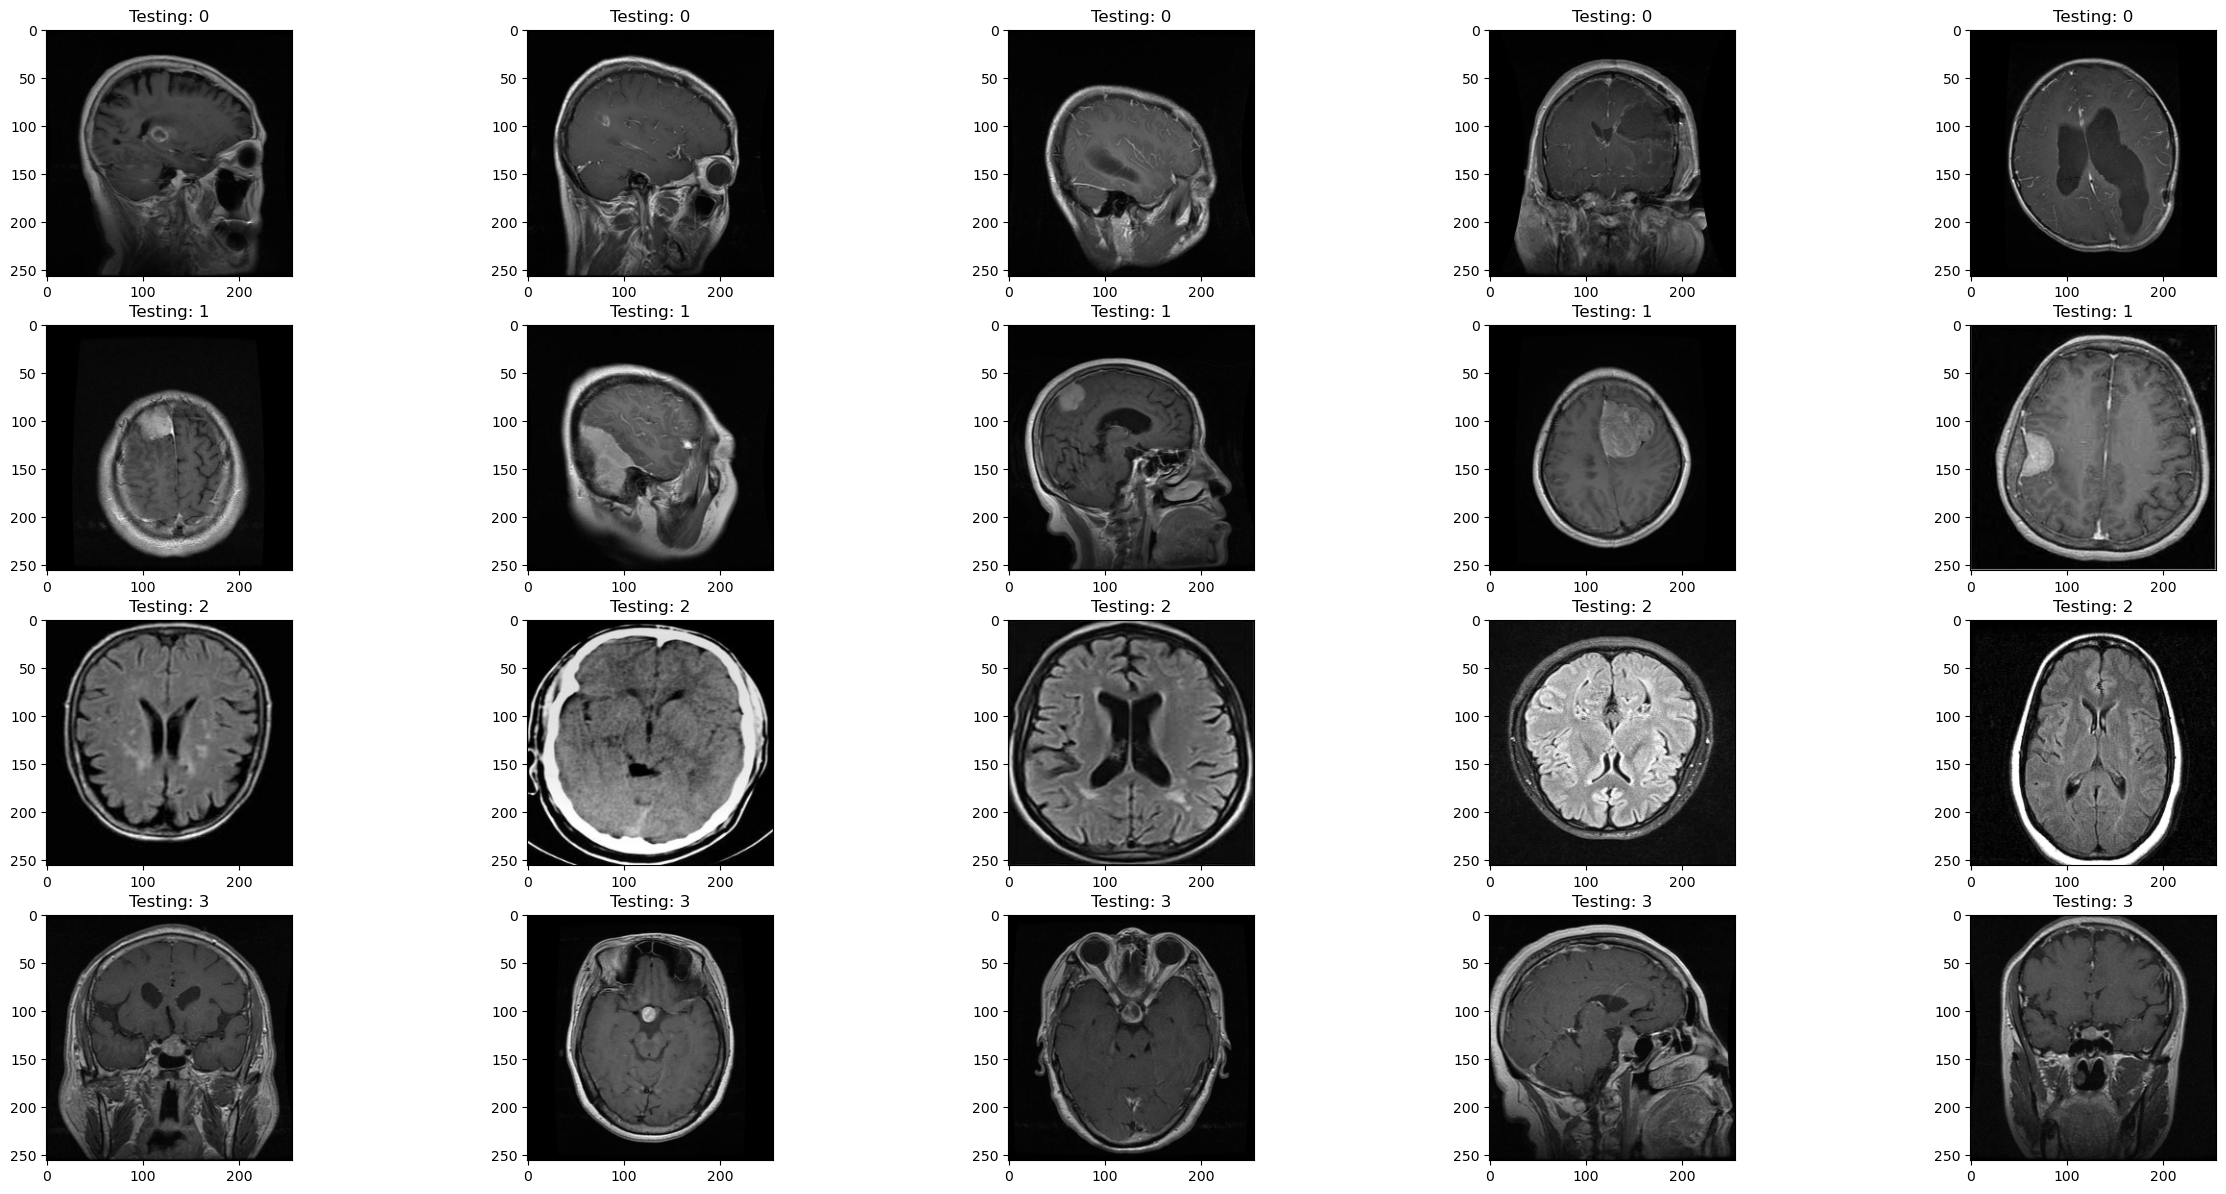

In [82]:
# Display some images from train_paths
plt.figure(figsize=(30, 30))

# Find indices for each label
test_indices_0: List[int] = np.where(np.array(test_labels) == 0)[0]
test_indices_1: List[int] = np.where(np.array(test_labels) == 1)[0]
test_indices_2: List[int] = np.where(np.array(test_labels) == 2)[0]
test_indices_3: List[int] = np.where(np.array(test_labels) == 3)[0]

# Randomly select 5 indices from each set
test_random_indices_0: List[int] = np.random.choice(test_indices_0, 5, replace=False)
test_random_indices_1: List[int] = np.random.choice(test_indices_1, 5, replace=False)
test_random_indices_2: List[int] = np.random.choice(test_indices_2, 5, replace=False)
test_random_indices_3: List[int] = np.random.choice(test_indices_3, 5, replace=False)

test_plot_indices: List[int] = np.concatenate([
    test_random_indices_0, 
    test_random_indices_1, 
    test_random_indices_2, 
    test_random_indices_3,
])

# Ensure indices are unique and within bounds
test_plot_indices = list(set(test_plot_indices))
test_plot_indices.sort()

for index, (image, label) in enumerate(zip(test_paths[test_plot_indices], test_labels[test_plot_indices])):
    plt.subplot(8, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title(f'Testing: {label}')
    
plt.show()

#### **2.4.5: Evaluating Testing Set Consistency**

The testing set holds a lot of the same properties as the training set. Most MRI scans here adhere to standard coronal, sagittal, and horizontal views, although potential outliers suggest oblique views exist in the set as well. Furthermore, the trend of T1 and T2 imaging bias is consistent, with a good amount of 'no tumor' images resembling T2-weighted scans and tumor-labeled images looking more like T1-weighted scans. The distribution of MRI scans across labels in the testing set also aligns closely with the training set. While this consistency is reassuring for model evaluation, the potential bias from T1 vs. T2 imaging discrepancy remains a concern. It's crucial to ensure the model's predictions are based on tumor presence or type and not incidental biases or image features.

## **3: Data Reduction**

### **3.1: Dimensionality Reduction with Principal Component Analysis**

Since images can be high-dimensional, linear dimensionality reduction techniques like Principal Components Analysis (PCA) can reduce the dimensionality of the image data. Reducing dimensionality makes computationally easier for further procesing and analysis.For example, reducing dimensionality helps make clustering, classification, and anomaly detection easier. 

Other applications of PCA for Machine Learning include reducing dimensionality and decorrelating features in order to improve the performance of machine learning algorithms by reducing the risk of overfitting and improving training time.

Let's take advantage of PCA and apply it to the brain MRI images. 

In [88]:
# Use full PCA for linearized image data
from sklearn.decomposition import PCA
aim_pca = PCA(svd_solver="full") # takes 16 minutes
aim_pca.fit(train_paths)

PCA(svd_solver='full')

Above, we performed PCA using all available components, allowing us choose a number of principal components based on the cumulative explained variance. While images should still be somewhat recognizable to human eyes, we can quantify the quality of the representation by aiming for a higher cumulative explained variance. A high cumulative explained variance indicates that a larger proportion of the data's variability was preserved after dimensionality reduction, which implies a better representation.

Let's get the cumulative explained variance. Let's also visualize the cumulative explained variance as we increase the number of principal components used.

Number of components explaining 95% variance: 1053
Number of components explaining 85% variance (shown): 322
Number of components explaining 70% variance: 97
Number of components explaining 50% variance (shown): 19


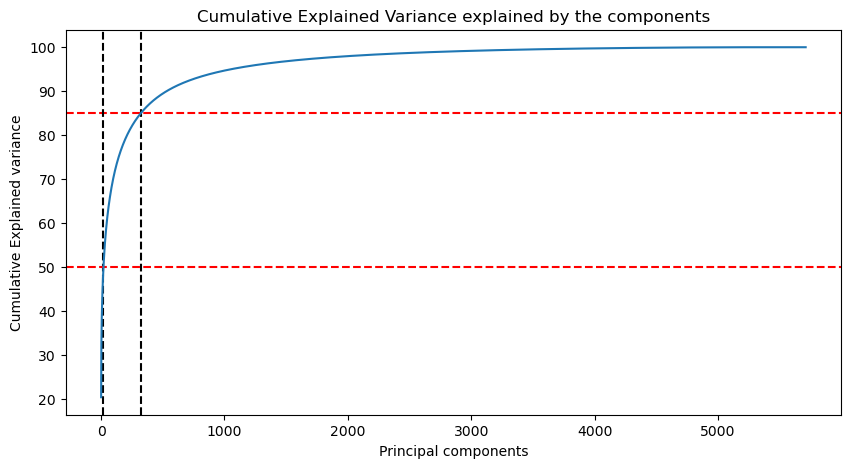

In [89]:
# Get cumulative variance
var_cumu = np.cumsum(aim_pca.explained_variance_ratio_)*100

# how many components explain 95% of the variance?
k95 = np.argmax(var_cumu > 95)
print("Number of components explaining 95% variance: "+ str(k95))

# how many components explain 85% of the variance?
k85 = np.argmax(var_cumu > 85)
print("Number of components explaining 85% variance (shown): "+ str(k85))

# how many components explain 70% of the variance?
k70 = np.argmax(var_cumu > 70)
print("Number of components explaining 70% variance: "+ str(k70))

# how many components explain 50% of the variance?
k50 = np.argmax(var_cumu > 50)
print("Number of components explaining 50% variance (shown): "+ str(k50))

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k85, color="k", linestyle="--")
plt.axhline(y=85, color="r", linestyle="--")
plt.axvline(x=k50, color="k", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
ax = plt.plot(var_cumu)

As shown in the Cumulative Explained Variance plot above, 95% cumulative explained variance can be achieved if we retain 1054 principal components. For the purposes of this project, 50% cumuluative explained variance can be achieved if we retain only 20 principal components. We will move forward retaining only 20 principal components.

To be more specific, we can visulize the first 50 principal components and their explained variance in a bar plot with the cumulative explained variance shown to be increasing with each additional component overlayed as a step plot.

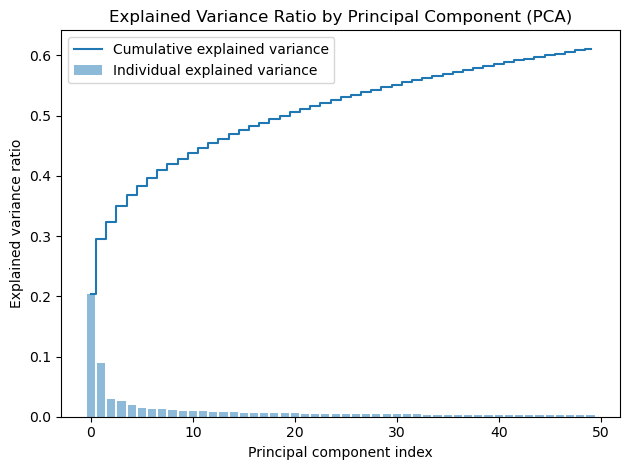

In [90]:
# Sklearn PCA class for determining Explained Variance: https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=determining%20explained%20variance-,Sklearn%20PCA%20Class%20for%20determining%20Explained%20Variance,-In%20this%20section
# 
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = aim_pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca[0:50])), exp_var_pca[0:50], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues[0:50])), cum_sum_eigenvalues[0:50], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained Variance Ratio by Principal Component (PCA)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As shown in the plot above, the cumulative explained variance only increases by small amounts when adding each additional component past 20 principal components, which is also where we achieved 50% cumulative explained variance. 

Let's perform PCA using 20 principal components in order to reconstruct the brain mri images from the first 20 principal components.

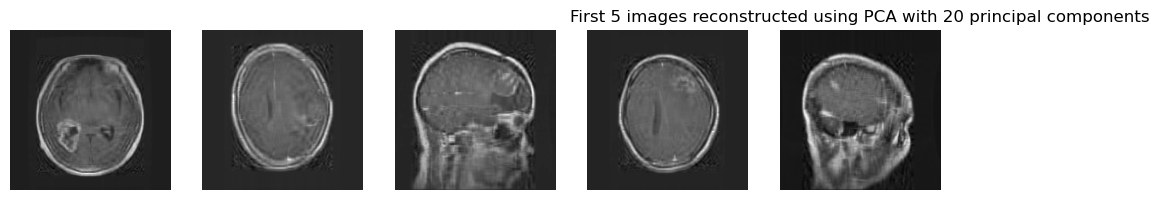

In [92]:
# Perform Image Reconstruction using PCA -> https://analyticsindiamag.com/guide-to-image-reconstruction-using-principal-component-analysis/
# -> 1.5 minutes to run
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Assuming trainPaths is a 2D array where each row represents an image
# and each column represents a pixel in that image.

# Set the number of principal components you want to retain
n_components = 20

# Create an empty array to store the reconstructed images
reconstructed_images = np.zeros_like(train_paths)

# Initialize IncrementalPCA (used when data is huge)
ipca = IncrementalPCA(n_components=n_components, batch_size=100)  # Adjust batch_size as needed

# Iterate through each image in trainPaths
for i in range(train_paths.shape[0]):
    image = train_paths[i, :].reshape(256, 256)  # Assuming each image is 256x256 pixels
    
    # Apply PCA to the current image
    transformed_image = ipca.fit_transform(image)
    
    # Reconstruct the image
    reconstructed_image = ipca.inverse_transform(transformed_image)
    
    # Store the reconstructed image
    reconstructed_images[i, :] = reconstructed_image.ravel()

# Plot some of the reconstructed images
num_images_to_plot = 5
plt.figure(figsize=(12, 8))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(reconstructed_images[i, :].reshape(256, 256), cmap=plt.cm.gray)
    plt.axis('off')

plt.title("First 5 images reconstructed using PCA with 20 principal components")
plt.show()

We conclude that selecting 20 principal components is more computationally efficient while still maintaining qualitative recognizability. Quantitatively, using 20 principal components yields 50% cumulative explained variance. After 20 components, adding each additional component provides diminishing returns.

### **3.2: Dimensionality with Randomized Principal Component Analysis**

Randomized PCA differs from standard PCA in terms of its computational approach, speed, and trade-offs. 

Randomized PCA approximates a set of principal components by using randomization. The goal is to find a low-rank approximation of the data matrix, while attempting to preserve as much variance as possible. Since it is an approximation, it is computationally faster for high-dimensional datasets and scales better for higher dimensionality feature spaces.
    
Standard PCA computes the exact principal components by using eigendecomposition or singular value decomposition of the data covariance matrix. Standard PCA computes an exact solution, which can be computationally expensive with large amounts of high dimensional data. While computationally expensive, standard PCA is needed when high accuracy and deterministic principal components are required.

Let's perform randomized PCA on the brain MRI image dataset while retaining all principal components.

In [93]:
# Randomized PCA on image dataset
from sklearn.decomposition import PCA
aim_rpca = PCA(svd_solver="randomized") # takes 15 minutes
aim_rpca.fit(train_paths)

# Get cumulative variance
var_cumu_rpca = np.cumsum(aim_rpca.explained_variance_ratio_)*100

For the same reasons stated above for standard PCA, a high cumulative explained variance indicates that a larger proportion of the data's variability was preserved, implying a better representation of the image.

After calculating the cumulative explained variance, we plot the cumulative explained variance as we increase the number of principal components.

Number of components explaining 95% variance: 1053
Number of components explaining 85% variance (shown): 322
Number of components explaining 70% variance: 97
Number of components explaining 50% variance (shown): 19


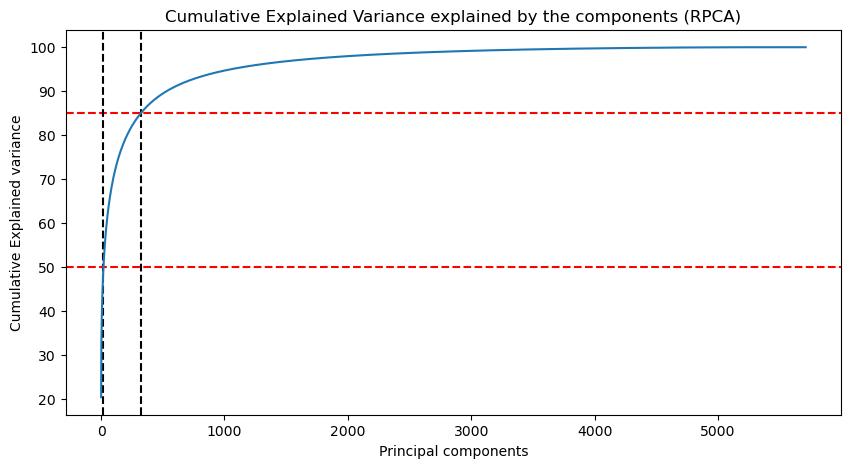

In [96]:
# how many components explain 95% of the variance?
k95_rpca = np.argmax(var_cumu_rpca > 95)
print("Number of components explaining 95% variance: "+ str(k95_rpca))

# how many components explain 85% of the variance?
k85_rpca = np.argmax(var_cumu_rpca > 85)
print("Number of components explaining 85% variance (shown): "+ str(k85_rpca))

# how many components explain 70% of the variance?
k70_rpca = np.argmax(var_cumu_rpca > 70)
print("Number of components explaining 70% variance: "+ str(k70_rpca))

# how many components explain 50% of the variance?
k50_rpca = np.argmax(var_cumu_rpca > 50)
print("Number of components explaining 50% variance (shown): "+ str(k50_rpca))

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components (RPCA)')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k85_rpca, color="k", linestyle="--")
plt.axhline(y=85, color="r", linestyle="--")
plt.axvline(x=k50_rpca, color="k", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
ax = plt.plot(var_cumu_rpca)

The randomized PCA key cumulative explained variance percentages of 95%, 85%, 70%, and 50% are achieved by the same numbers of principal components as standard PCA, respectively.

To show this, we visualized the first 50 principal components and their explained variance in a bar plot with the randomized PCA cumulative explained variance shown to be increasing with each additional component overlayed as a step plot. To the naked eye, the plots for randomized PCA and standard PCA look very similar.

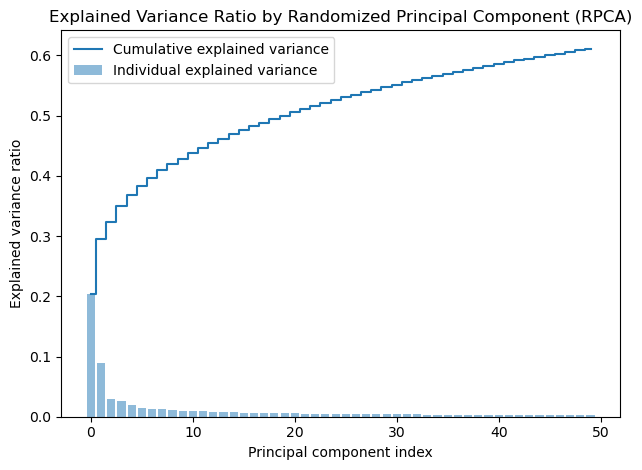

In [97]:
# Sklearn PCA class for determining Explained Variance: https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=determining%20explained%20variance-,Sklearn%20PCA%20Class%20for%20determining%20Explained%20Variance,-In%20this%20section
# 
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_rpca = aim_rpca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues_rpca = np.cumsum(exp_var_rpca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_rpca[0:50])), exp_var_rpca[0:50], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_rpca[0:50])), cum_sum_eigenvalues_rpca[0:50], where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("Explained Variance Ratio by Randomized Principal Component (RPCA)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As shown in the plot above, the cumulative explained variance only increases by small amounts when adding each additional component past 20 principal components, which is also where we achieved 50% cumulative explained variance. This is very similar to the same plot generated for standard PCA.

Let's perform randomized PCA using 20 principal components in order to reconstruct the brain mri images from the first 20 principal components. We'll output the first 5 reconstructed images. 

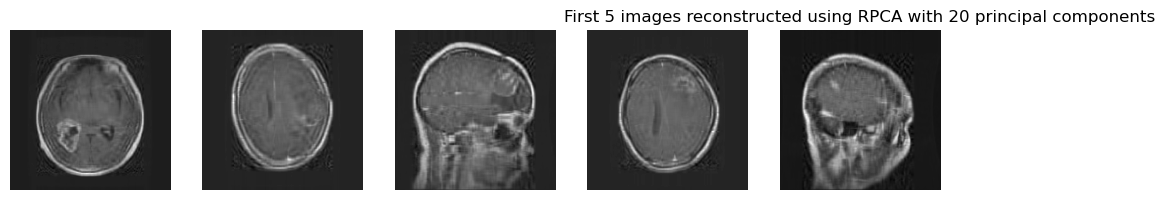

In [95]:
# Perform Image Reconstruction using RPCA -> https://analyticsindiamag.com/guide-to-image-reconstruction-using-principal-component-analysis/
# -> 1.5 minutes to run
import numpy as np
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Assuming trainPaths is a 2D array where each row represents an image
# and each column represents a pixel in that image.

# Set the number of principal components you want to retain
n_components = 20

# Create an empty array to store the reconstructed images
reconstructed_images = np.zeros_like(train_paths)

# Initialize RPCA
rpca = PCA(n_components=n_components, svd_solver="randomized")

# Iterate through each image in trainPaths
for i in range(train_paths.shape[0]):
    image = train_paths[i, :].reshape(256, 256)  # Assuming each image is 256x256 pixels
    
    # Apply PCA to the current image
    transformed_image = rpca.fit_transform(image)
    
    # Reconstruct the image
    reconstructed_image = rpca.inverse_transform(transformed_image)
    
    # Store the reconstructed image
    reconstructed_images[i, :] = reconstructed_image.ravel()

# Plot some of the reconstructed images
num_images_to_plot = 5
plt.figure(figsize=(12, 8))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(reconstructed_images[i, :].reshape(256, 256), cmap=plt.cm.gray)
    plt.axis('off')

plt.title("First 5 images reconstructed using RPCA with 20 principal components")
plt.show()


### **3.3: Compare PCA and Randomized PCA**

The same 5 brain MRI images are reconstructed and outputted using PCA and randomized PCA at the end of each section, respectively. The quality looks about the same. Additionally, as discussed in the prior sections, the PCA and randomized PCA explained variance visualizations also look very similar. Could it be that applying PCA and randomized PCA to the images yielded the same principal components?

We can verify that statement by printing some of the components, and furthermore, checking for equality.

In [98]:
print ('pca:\n', ipca.components_)
print ('rpca:\n', rpca.components_)
# check if the PCA components equal the RPCA components. Are they exactly the same?
print(ipca.components_ == rpca.components_)

pca:
 [[-0.00125565 -0.00212861 -0.00273157 ... -0.00214003 -0.00144037
  -0.00092506]
 [-0.00030348 -0.00057865 -0.00035808 ... -0.00021132 -0.00017052
  -0.00010983]
 [ 0.00073641  0.00126805  0.00156243 ...  0.00135461  0.00093436
   0.00060559]
 ...
 [ 0.00066167  0.00142796  0.0018673  ...  0.00110554  0.00070305
   0.00041678]
 [ 0.00035167  0.00070993  0.00178789 ...  0.00100288  0.00055268
   0.00038285]
 [ 0.00117691  0.00180216  0.00264288 ...  0.00212684  0.00150235
   0.00099536]]
rpca:
 [[-0.00125513 -0.00212739 -0.00273202 ... -0.00213932 -0.00143989
  -0.00092475]
 [ 0.00030494  0.00058087  0.00035984 ...  0.00021315  0.00017177
   0.00011064]
 [ 0.00073652  0.00126772  0.00156659 ...  0.00135507  0.00093461
   0.00060571]
 ...
 [ 0.00080252  0.00160749  0.0019152  ...  0.00130214  0.0008488
   0.00051171]
 [ 0.00036087  0.00071596  0.00195715 ...  0.00100558  0.00053197
   0.00035913]
 [-0.00159964 -0.00242542 -0.00321388 ... -0.00277361 -0.00198344
  -0.00130208]]
[[Fa

As verified in the printed output, the calculated principal components for standard PCA and randomized PCA are not the same. While the reconstructed images and explained variance visualizations looked the same at a glance, we shouldn't expect the components to be exactly the same. 

Randomized PCA calculates an approximation of the principal components, while standard PCA calculates the exact principal components with high accuracy. The two should be similar, given that they were applied to the same image data with the same number of retained principal components (20), but they should not be equivalent. 

In terms of whether PCA or RPCA is better, we need to consider some of the factors discussed earlier (computational approach, speed, and trade-offs). Deciding which is "better" can depend on your use case. For our use case, with large amounts of high-dimensional data, randomized PCA is advantageous because it is computationally efficient and faster to approximate principal components. However, because of the medical application and potential loss of life, high-accuracy calculations, and therefore standard PCA, are preferred even if it is less cost-effective. We prefer standard PCA over randomized PCA for this application due to its high-risk potential. 

## **4: Predictive Analysis using ResNet & Deep-Dive into Feature Extraction**

In [8]:
# Instantiate the ResNet50 model
resnet50: models.ResNet = models.resnet50(pretrained=True)

### **4.1: Overview of ResNet50**

We decided to use a PyTorch implementation of the <a href="https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet">Residual Network (ResNet)</a> architecture for prediction. The ResNet architecture was introduced by Kaiming He et al. in their 2016 paper titled "Deep Residual Learning for Image Recognition."

To summarize, ResNet introduced a novel architecture to deal with the vanishing gradient problem that occurs when training very deep neural networks. Other deep neural networks before ResNet faced several challenges that hampered their performance. As these networks became deeper, the gradients, which are crucial for weight updates during training, tended to become <a href="https://www.engati.com/glossary/vanishing-gradient-problem#:~:text=Vanishing%20gradient%20problem%20is%20a,layers%20to%20the%20earlier%20layers.">exceedingly small</a>. This phenomenon, known as the vanishing gradient problem, led to a situation where the weights of neurons, especially in the earlier layers, barely updated. As a result, these layers would learn at a very slow pace, changing negligably or not even at all. These layers, which were often responsible for capturing essential features of input data, are critical for the overall performance of the network. 

To address these challenges, ResNet introduced "residual learning." Central to ResNet are its <a href="https://towardsdatascience.com/resnets-residual-blocks-deep-residual-learning-a231a0ee73d2">residual blocks</a>, which incorporate "skip" or "shortcut" connections. These connections allow input information to bypass one or more layers and directly feed into more relevant layers. This design ensures that even during backpropagation—when a neural network is correcting its parameters when evaluating its performance on the training data at hand—the gradient can flow without significant changes across parameters in the network. By doing so, ResNet alleviates the vanishing gradient problem, enabling the weights in earlier layers to update more effectively. This revitalizes the training dynamics and ensures that deep networks can learn and generalize better without experiencing the vanishing gradient problem like other networks in the past.

ResNet50 specifically has 50 layers and bottleneck building blocks made up of a $1 \times 1$ convolution, a $3 \times 3$ convolution, then another $1 \times 1$ convolution to reduce the number of input and output features once arriving to the $3 \times 3$ convolution. It is known to be a good balance in comparison to other ResNet architectures when it comes to runtime and performance.

### **4.2: ResNet Model Performance Evaluation**

#### **4.2.1: Fine-Tuning ResNet50**

In [13]:
%%time
# ChatGPT assisted in the generation of this code block, but it was largely translated into
# a format we found more readable with comments added throughout the code block.

# 1. Prepare the ResNet50 model for transfer learning
# 
# This replaces the last fully connected layer (originally trained for 
# the 1000-class ImageNet dataset) with a new fully connected layer that matches the 
# number of classes in our MRI dataset. Since this layer is newly initialized, it 
# contains random weights and will be trained from scratch, while the other layers 
# contain pre-trained weights from ImageNet.
NUM_CLASSES: int = len(labels)
resnet50.fc: torch.nn.Module = (
    torch.nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Send the model to the selected device 

# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 32
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,  # No need to shuffle test data
    )
)

# 3. Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop (THIS LOOP WAS GENERATED BY CHATGPT)
NUM_EPOCHS: int = 10
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set the model to training mode
    train_loss: float = 0.0  # Initialize training loss
    
    # For each batch of images and labels
    for images, labels in train_loader:
        images: Tensor = images.to(device)  # Send data to the device (GPU/CPU)
        labels: Tensor = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs: Tensor = resnet50(images)  # Forward pass: Get model predictions
        loss: Tensor = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

    # Print average training loss for this epoch        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training loss: {train_loss/len(train_loader)}")

# 4. Evaluate the model
resnet50.eval()  # Set the model to evaluation mode
correct: int = 0  # Count of correct predictions
total: int = 0   # Total number of images processed

# We won't update the model, so we tell PyTorch not to compute gradients
with torch.no_grad():
    for images, labels in test_loader:
        images: Tensor = images.to(device)
        labels: Tensor = labels.to(device)
        outputs: Tensor = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Print the accuracy of the model on the test data
print(f"Accuracy of the model on test images: {100 * correct / total}%")

Epoch 1/10 - Training loss: 0.40997146692272673
Epoch 2/10 - Training loss: 0.2255835798803155
Epoch 3/10 - Training loss: 0.18322483100017856
Epoch 4/10 - Training loss: 0.1404304561106353
Epoch 5/10 - Training loss: 0.1046861873122775
Epoch 6/10 - Training loss: 0.11053353990168004
Epoch 7/10 - Training loss: 0.08580488711660572
Epoch 8/10 - Training loss: 0.09573174216563413
Epoch 9/10 - Training loss: 0.10703581512005553
Epoch 10/10 - Training loss: 0.03626974687118775
Accuracy of the model on test images: 93.74523264683448%
CPU times: user 13h 14s, sys: 3h 41min 7s, total: 16h 41min 21s
Wall time: 4h 8min 17s


#### **4.2.2 Evaluating Performance in Practical Context**

Here is what the output looked like on a machine with a CUDA-accelerated GPU:

```
cuda:0
Epoch 1/10 - Training loss: 0.4171058736616673
Epoch 2/10 - Training loss: 0.24048794202464918
Epoch 3/10 - Training loss: 0.17606037150673026
Epoch 4/10 - Training loss: 0.1445209681974755
Epoch 5/10 - Training loss: 0.11966687487308249
Epoch 6/10 - Training loss: 0.10562789063203518
Epoch 7/10 - Training loss: 0.0759450301941609
Epoch 8/10 - Training loss: 0.07359373944358868
Epoch 9/10 - Training loss: 0.07474656748408504
Epoch 10/10 - Training loss: 0.07426049515563349
Accuracy of the model on test images: 96.5675057208238%
CPU times: total: 37min 19s
Wall time: 10min 44s
```

Based on the given output of the ResNet model fine-tuned on MRI brain scans, we can make several observations about its performance in differentiating tumor types: `glioma`, `meningioma`, `no_tumor`, and `pituitary`. The model began with a high initial loss of 0.410 in the first epoch, signifying initial challenges in making accurate predictions. However, a rapid decline in training loss over subsequent epochs, culminating in a very low 0.036 by the 10th epoch, indicates that the model was effectively learning from the training data. When tested on unseen data, the model achieved 93.75% prediction accuracy.

 In a medical setting, this high accuracy is promising, suggesting the model's ability to generalize well. We are a little surprised about the strong performance of our model because of the fact that the MRI scans in our dataset come from a multitude of captured angles. However, it's crucial to highlight the importance of other performance metrics, especially the sensitivity score in predicting the existence of a tumor rather than false negatives in failing to detect a tumor when one existed. In the broader context of MRI brain scanning, the ability to accurately differentiate between the given tumor types is important, given the distinct characteristics and treatments associated with each. However, the actual sensing of a tumor is so much more important. 
 
 Saying a tumor does not exist when one does can lead to severe medical implications, as the patient not receiving the necessary treatment in time, potentially resulting in disease progression or even fatality. On the other hand, a false positive, while causing pain and suffering and leading to additional unnecessary diagnostic procedures taking up the patient and medical professions' time, doesn't carry the same immediate life-threatening implications. 
 
 Still, expert radiologists should always be consulted for the final interpretation, and a machine learning model fine-tuned by college students with little medical domain knowledge should not be trusted blindly. Collaborative feedback from radiologists can provide more specific insights, helping in refining the model and ensuring it aligns better with clinical needs. In essence, while the ResNet model exhibits promising preliminary results, continued refinements should be explored by ensuring that the collected data came from effects seen long after the initial MRI screening (in that case, strong bias from doctors and technicians would not be captured), and the angles where the MRI screens were taken should be captured as well.
 
 On an M1 Mac, the total CPU time was around 16 hours and 41 minutes. Whereas, total GPU time on a CUDA-accelerated GPU was 10 minutes and 44 seconds. This makes sense, as M1 Mac's are not CUDA-compatible, and therefore the operations here were not parallelized nearly as efficiently as how a GPU would perform. 

#### **4.2.3: Visualizing Performance in Context With Confusion Matrix**

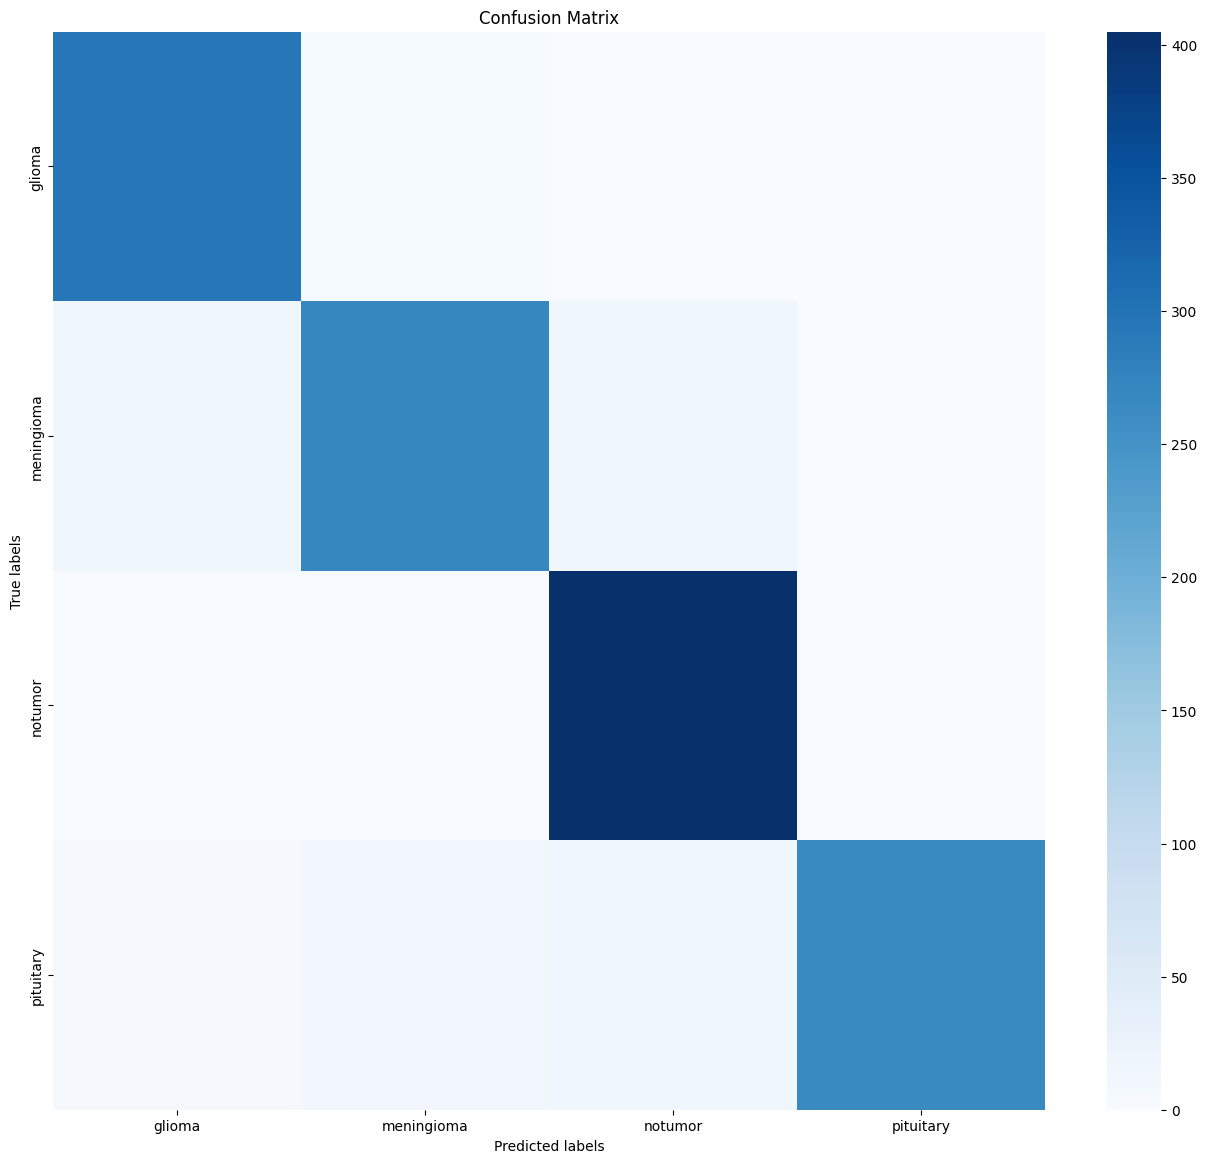

Number of False Negatives for glioma (Predicted as Not a Tumor): 1
Number of False Negatives for meningioma (Predicted as Not a Tumor): 17
Number of False Negatives for pituitary (Predicted as Not a Tumor): 15

Confusion Matrix:

 [[295   4   1   0]
 [ 17 271  17   1]
 [  0   0 405   0]
 [  6  14  15 265]]


In [55]:
# Instantiate Lists
all_labels = []
all_predictions = []

# Extract Labels and Predictions
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Create Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot Confusion Matrix
plt.figure(figsize = (16, 14)) 
sns.heatmap(cm, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print Number Of False Negatives, Confusion Matrix Values
for i in [0, 1, 3]:
    false_negatives = cm[i, 2]
    print(f"Number of False Negatives for {labels[i]} (Predicted as Not a Tumor): {false_negatives}")
print('\nConfusion Matrix:\n\n', cm)

The provided confusion matrix showcases invaluable insights. Not a single instance of false positives is observed for brain scans where in reality a tumor does not exist—a characteristic which might stem from the challenges presented by T1 and T2 imaging or the obviousness of a lack of a tumor being true. The MRIs with more white resonation (a.k.a. the T2-imaging MRI's with no tumors from the different dataset than the other brain scans) might be a contributing factor in skewing these predictions. Alternatively, the absence of tumors might have been so clear that the model never misidentified a non-tumor as a tumor. While on the surface, this might seem amazing, our primary concern here for medical efficacy is the existence of false negatives. Misclassifying existing tumors as non-existent can carry severe consequences, potentially escalating symptoms that could be fatal. In contrast, detecting tumors when none are present may cause momentary stress but doesn't carry life-threatening consequences. The heatmap illuminates a different perspective from the initially perceived 94% model accuracy, revealing that the errors, although few, could be much more problematic than originally expected.

That said, the model's performance is strong nonetheless. Glioma tumors are rarely misdiagnosed, and only about 6% of meningioma tumors and 5% of pituitary tumors are falsely identified as non-existent. It's worth noting, however, that pituitary tumors seem more challenging to identify, with a greater frequency of misclassification compared to other tumor types. This could indicate that pituitary tumors may possess visual characteristics that overlap with those of glioma and meningioma tumors, or even exhibit characteristics similar to the absence of tumors, as seen by the 15 misclassified instances in our test dataset.

### **4.3: Feature Extraction Methods Behind ResNet**

The structure of our `resnet50` model is shown below:

In [31]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The ResNet50 architecture begins with 2D convolutional layers designed to extract fundamental patterns, such as edges and textures, from the MRI images. Following the convolutional layers, a 2D batch normalization layer stabilizes the learning by normalizing the layer's input. Then, the ReLU activation function $f(x) = \max{(0,x)}$ introduces non-linearity and removes negative numbers, ensuring that the model can capture more intricate relationships in the data.

Post-activation, a max pooling layer is utilized, which downsamples the spatial dimensions by retaining the most dominant features, ensuring computational efficiency and preventing overfitting. This is succeeded by a series of four sequential layers. These layers progressively recognize more sophisticated patterns by combining the basic patterns learned in the earlier layers.

Upon traversing these sequential layers, the architecture introduces an average pooling layer, further compressing the spatial dimensions by taking the average value over a defined window. Concluding the model is a linear layer responsible for the final classification decision. This model was then fine-tuned on the MRI dataset, where backpropagation was applied to adjust the weights of the ResNet model according to the specificities of the MRI data.

For a more detailed introspection into the model's decision-making process, plotting the feature maps can offer insights. By visualizing the outputs up to and including `layer3`, we can observe the hierarchical patterns and features that the model leverages to make its classifications. This offers a profound understanding of ResNet's intermediate workings with the MRI images and can elucidate any potential pitfalls or biases in its interpretation.

We will run this line of code to take a look at how ResNet is interpreting the MRI images up to and including `layer3` of the model as seen in the architecture above.

```{Python}
intermediate_layer_model: torch.nn.Sequential = (
    torch.nn.Sequential(*list(resnet50.children())[:8]) # Including up to layer3
)
```

Below is the full code for displaying these feature maps.

Intermediate output shape is of shape (1, 2048, 8, 8).


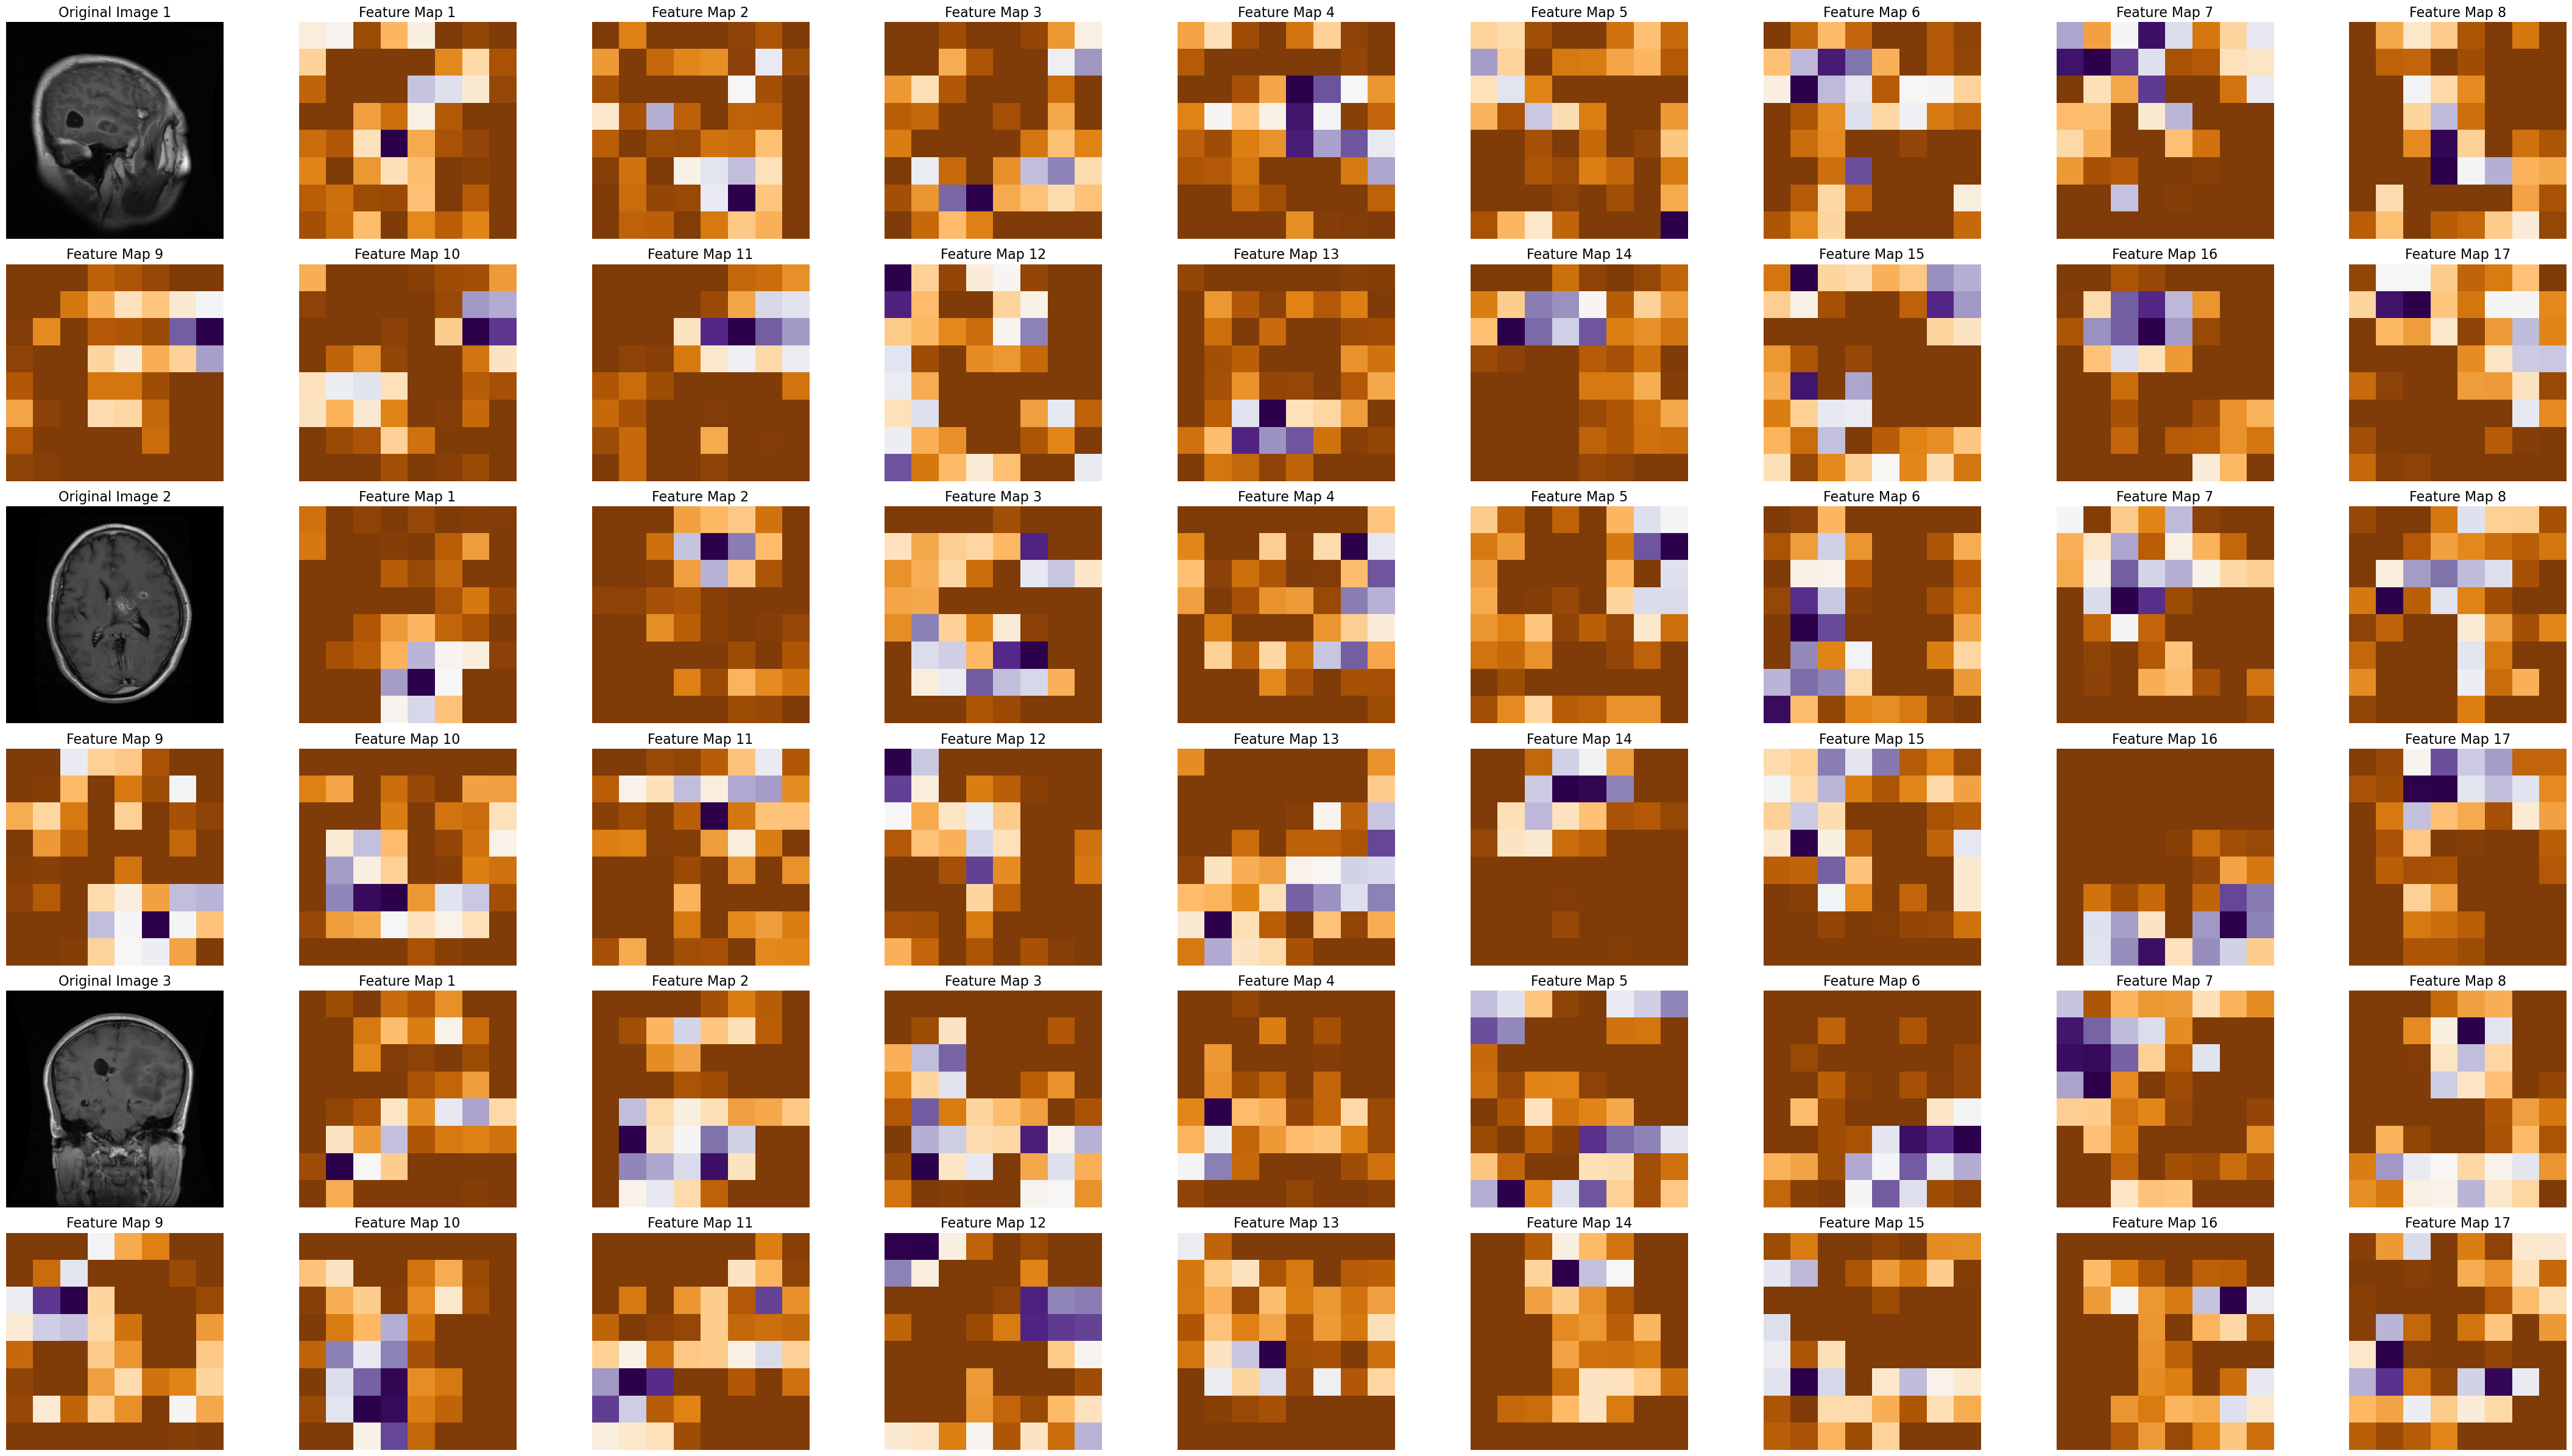

In [53]:
# ChatGPT assisted in the generation of this feature map code, with adjustments made
# for legible static typing and comments made to showcase understanding. 

# Extract the model up to the desired layer
intermediate_layer_model: torch.nn.Sequential = (
    torch.nn.Sequential(*list(resnet50.children())[:8]) # Including up to layer3
)
intermediate_layer_model.to(device)

# Get the first test image and add a batch dimension
test_image_tensor: Tensor = test_tensors[0].unsqueeze(0).to(device)

# Ensure model does not get modified, and showcase output
with torch.no_grad():
    intermediate_output = intermediate_layer_model(test_image_tensor)

# Number of feature maps to visualize
NUM_FEATURE_MAPS: int = 17

# Output shape to understand inner-workings
INTERMEDIATE_OUTPUT_SHAPE: Tuple[int,int,int,int] = tuple(intermediate_output.shape)
print(f"Intermediate output shape is of shape {INTERMEDIATE_OUTPUT_SHAPE}.")

# print(f"The intermediate ")

plt.figure(figsize=(44, 24))  # Adjust the figure size for clarity

# Loop for three images
for i in range(3):
    # Get the test image and add a batch dimension
    test_image_tensor: Tensor = test_tensors[i].unsqueeze(0).to(device)

    # Ensure model does not get modified, and showcase output
    with torch.no_grad():
        intermediate_output = intermediate_layer_model(test_image_tensor)
    
    # Plot the original image first
    plt.subplot(6, 9, 1 + i*18)  # Adjust subplot grid to include one more for the original image and position it correctly
    original_img = test_image_tensor[0].cpu().numpy().transpose(1, 2, 0)
    plt.imshow(original_img, cmap='gray' if original_img.shape[2] == 1 else None)  # Display as grayscale if it's a single-channel image
    plt.axis('off')
    plt.title(f'Original Image {i+1}', fontdict={'size': 16})  # Title only for the first row to avoid repetition
    
    # Plot the feature maps
    for j in range(NUM_FEATURE_MAPS):
        plt.subplot(6, 9, j + 2 + i*18)  # Adjust indices to leave space for the original image and position it correctly for each image row
        plt.imshow(
            intermediate_output[0, j].cpu().detach().numpy(),  # Showcases feature maps for each index shown
            cmap='PuOr',  # Use 'PuOr' colormap for better visualization
        )  
        plt.axis('off')
        plt.title(f'Feature Map {j+1}', fontdict={'size': 16})  # Title only for the first row to avoid repetition

plt.tight_layout()
plt.show()

In the plot above, we output the contrasting values of numbers stored in 17 of the 2048 feature maps for 3 MRI images. 

We can't visually interpret exactly what is going on from the feature extraction process of a Convolutional Neural Network like ResNet, but the generated feature maps offer a look into the network's perception of the input image at certain stages of traversing through a deep neural network. Each feature map represents the result of dot products and/or applications of activation functions from different filters within the convolutional layers, highlighting various aspects and features of the input. Some maps might amplify edges, while others may focus on textures or more abstract patterns. In the feature maps, we can see how the pooling operations, for example, reduce dimensionality and compress the high dimensional images into a heatmap of size $8 \times 8$, reducing the noise in the overall image and capturing more complex features that can shed light on certain properties of each image. (ChatGPT assisted in writing this paragraph, but we heavily modified it)

In the realm of brain MRI imaging, understanding these feature maps is especially crucial. They underscore the network's capacity to identify and respond to subtle nuances in the images—nuances that could mean the difference between detecting a potential tumor in an MRI scan and overlooking it. As data from an image progresses through ResNet's layers, these features become more refined and abstract, preparing the network to make its final classifications or predictions with a rich context. Even though the intricate details of these feature maps are not susceptible to human interpretation, for the neural network, they showcase informed and accurate decision-making.

As a whole, we can say that in spite the lack of human interpretability, with the high accuracy in prediction achieved from ResNet50 with 94% on the testing data running on an M1 mac, this feature extraction method performs extremely well in the prediction task of classifying tumors in MRI images. 

## **5: Exceptional Work (Meta DinoV2 Implementation)**

### **5.1: Overview of DinoV2**

We have chosen to implement Meta DinoV2, a series of base models that generate universal features applicable for various image-level visual tasks. These tasks include image classification, instance retrieval, and video comprehension. Moreover, these features also facilitate pixel-level visual tasks like depth estimation and semantic segmentation.

We carry out Dense Matching that boasts state-of-the-art results, and impressive generalization in evaluating depth from a single image. We also conduct Depth Estimation, which utilizes DinoV2 patch features for consistently mapping all portions of an image without supervision. 

Subsequently, we classify the results using a pre-trained Vision Transformer (ViT) with an additional linear probe for our classification task. To ensure efficient operation, we initially free up memory in the GPU by killing the existing kernel before executing the following code. This helps to prevent system crashing and enables smooth loading of the Vision Transformer.

***Disclaimer***: All references and resources utilized can be found at the end of this notebook. These include numerous sources such as the official DinoV2 repository and various Medium articles which feature the implementation of these models which we have taken inspiration from.

### **5.2: Kill Kernel Code for Emptying Cache**

In [ ]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

Illegal memory access would occur with our CUDA implementation of DinoV2 because our machine with the CUDA-accelerated GPU had 8G of VRAM, so we kept this code block above to clear the cache when needed.

### **5.3: Additional Imports for DinoV2 Implementation**

In [1]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os
import math
import itertools
from functools import partial
from tqdm.notebook import tqdm

# Data Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import mmcv
from mmengine.runner import load_checkpoint
import torch
from torch import Tensor
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional

# Other
import sys
import gc
import urllib
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

### **5.4: Direction Overview With DinoV2 Implementation**

In the initial steps of our project, we add the DinoV2 repository to our current path and import the required libraries from this repository. Following this, we deploy a pre-trained Vision Transformer (ViT) model. For operations pertaining to Dense Matching and Depth Estimation, we use the giant model (4.2 Gigabytes) to maximize the effectiveness of these tasks. Conversely, for users with resource limitations, a smaller model is offered. During the classification task, we make use of the base model, as it operates optimally for this process (and I don't hate my laptop). Note that in this section, we have also configured the device for GPU usage to expedite processing. We then reload the dataset and specify the number of classes for our classification task. Since we've already explained this process, we'll proceed without further explanation.

In [2]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

# DinoV2 Imports (Includes OpenMMLabs)
from dinov2.eval.depth.models import build_depther

In [3]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "giant" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)
backbone_model.eval()
backbone_model.cuda()

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [4]:
# Reload Information (Same As Before)

# Load Train / Test Data (Set IMG_SIZE = 256, Can Be <= 512)
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding (0, 1, 2, 3)
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # train_paths: List Of Numpy Arrays Specifying Training Data
train_labels: List[int] = []        # train_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)
test_paths: List[np.ndarray] = []   # test_paths: List Of Numpy Arrays Specifying Testing Data
test_labels: List[int] = []         # test_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0)

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0) 

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

In the following code, we're setting up and performing a variety of image processing tasks for feeding to a machine learning model. The approach is influenced by the methods proposed in the DinoV2 research paper. Initially, we're defining two sets of transformations that need to apply to our images. 'transform' and 'transform1' use the torchvision.transforms.Compose function for creating a composition of several transforms. Both the transformations include resizing and center cropping the image. Additionally, the transforms also convert the image to tensor format allowing it to be used within PyTorch and normalize the tensor by setting the mean and standard deviation as described.

Then we get the patch size from the backbone model which is used to perform an integer division on the size of the image, resulting in the patch width and height. We follow this by defining a dictionary of feature dimensions that can be fed to the model, and we set up an empty list to store all features that will be extracted from the images. A nested loop is set up to traverse over all of the labels for supplied images. For each image file, we're preparing the image to extract features for further processing. This includes opening the file, converting it to RGB format, transforming it, and then feeding it through the model to gather features, which are extracted and appended to a list. 

After each label's images have been processed, features are concatenated together and reshaped into the desired format corresponding to the ability of the neural network model's capability. Finally, the processed images are converted into numpy array. The code finishes by outputting the shape of the final concatenated features, giving an idea of the data's final form before it goes into the learning model.

In [5]:
# Transform Data (Convert To Tensors - 256 Standard Size, 224 Center Crop)
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                transforms.ToTensor(), transforms.Normalize(
                                mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Add Transforms To Load Images (518 * 518 Resize As Shown In The Paper)
transform1 = transforms.Compose([transforms.Resize(512), transforms.CenterCrop(518), # Should Be Multiple Of Model Patch Size              
                                transforms.ToTensor(), transforms.Normalize(mean = 0.5, std = 0.2)]) # Normalization

In [6]:
# Grab Patch Size From Backbone Model (Patch Size = 14)
patch_size = backbone_model.patch_size

# Perform Integer Division With Patch Size (520 / 14 = 37)
patch_h  = 520 // patch_size
patch_w  = 520 // patch_size

# Choose Feature Dimension (Depends On Backbone Size)
feat_dims = {"small": 384, "base": 768, "large": 1024, "giant": 1536} 
feat_dim = feat_dims[BACKBONE_SIZE]

# Create Empty List For Features
total_features  = []

# Keep Same Images For Later
used_images = []

# Loop Through Labels (No Gradient Updating)
with torch.no_grad():
    for label in labels:
        for img_file in glob.glob('Dataset/Training/' + f'/{label}/*.jpg'):

            # Open Image File, Convert To RGB
            img = Image.open(img_file).convert('RGB')

            # Append Image To List
            used_images.append(cv2.resize(cv2.imread(img_file, 0), (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0)

            # Transform (Keeping Data Same), Force Data Onto Same Device
            img_t = transform1(img).to(device)

            # Forward Pass (Get Features)
            features_dict = backbone_model.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)

            # Only Get One Of Each Label
            break

# Concat Features Together
total_features = torch.cat(total_features, dim = 0)
total_features.shape

# Convert To Numpy Array
used_images = np.array(used_images)

### **5.5: DinoV2 PCA Analysis**

The provided code effectively performs feature visualization via Principal Component Analysis (PCA) on patches of images. It starts by restructuring the image features into a two-dimensional array, making it compatible with sklearn's PCA method. The PCA is initiated with three components according to a referenced research paper, implying three primary features will be extracted. The PCA model is then fitted to the data, which is subsequently transformed for PCA space analysis. 

Histograms of the three components are plotted post-transformation, which visualizes the principal components and aids in setting a suitable threshold later on. The first component is then min-max scaled, ranging from 0 to 1, and plotted for visualization. After setting a threshold, the first component is segmented into foreground and background, and the segments are visualized and plotted. A second PCA is then conducted exclusively on the foreground, and the RGB values of these patches are adjusted.

PCA plays an essential role in image processing, particularly in distinguishing the background from the subject of an image. This is especially useful in tasks that involve object detection or segmentation. Moreover, PCA aids in capturing local features that could be overlooked when analyzing an entire image, helping to reduce computational costs and improve accuracy. 

The use of PCA on smaller patches instead of the whole image allows for the capture of nuanced local features that might be overlooked when the whole image is analyzed. As background patches are set to black to enhance contrast in the final image, the scaled PCA results for the foreground patches are plotted, resulting in four visualized images. Overall, the application of PCA to image patches offers a robust tool for feature analysis, dimensionality reduction, and data visualization.


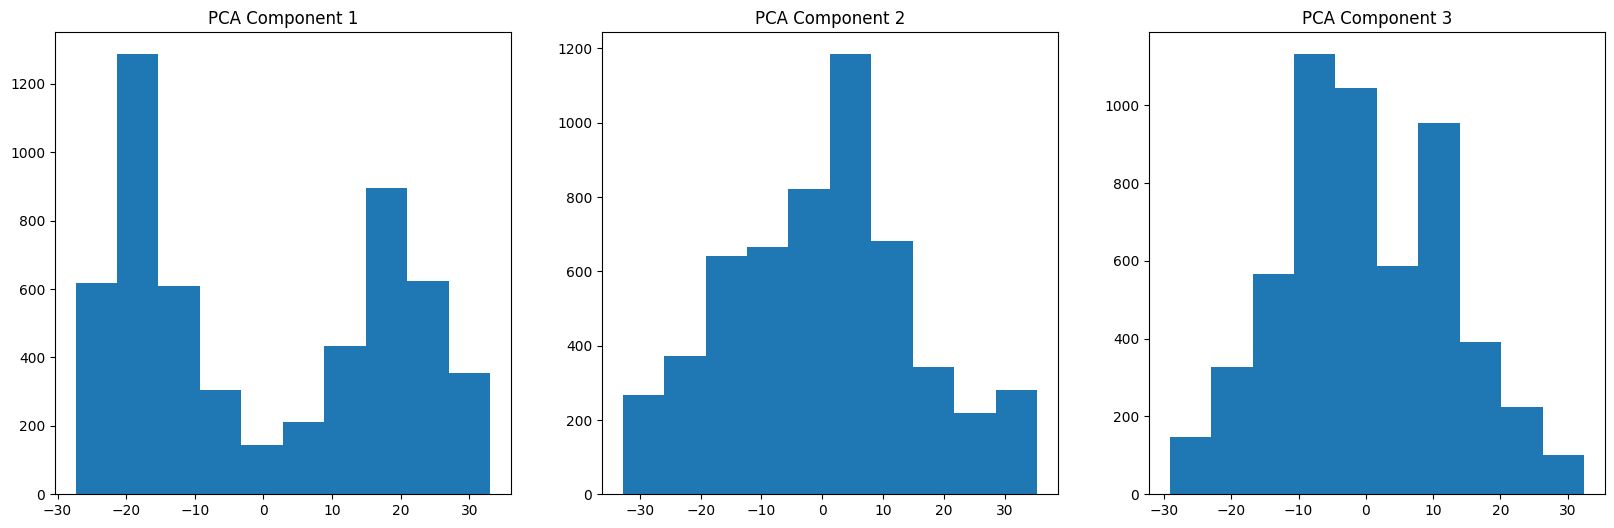

In [7]:
# First PCA => Seperate Background, Sklearn Expects 2D Array (4 * H * W, 1024)
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim)

# Perform PCA With Three Components - As Mentioned In Paper
pca = PCA(n_components = 3)

# Copy CUDA Tensor To CPU Memory
cpu_tensor = total_features.cpu()

# Convert CPU Tensor To NumPy Array
numpy_array = cpu_tensor.numpy()

# Fit PCA Model To Data, Transform Data
pca.fit(numpy_array)
pca_features = pca.transform(numpy_array)

# Visualize PCA Components For Finding A Proper Threshold - 3 Histograms For 3 Components
plt.figure(figsize = (20, 6))

# Plot PCA Component 1
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.title("PCA Component 1")

# Plot PCA Component 2
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.title("PCA Component 2")

# Plot PCA Component 3
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.title("PCA Component 3")

# Show, Close Plot
plt.show()
plt.close()

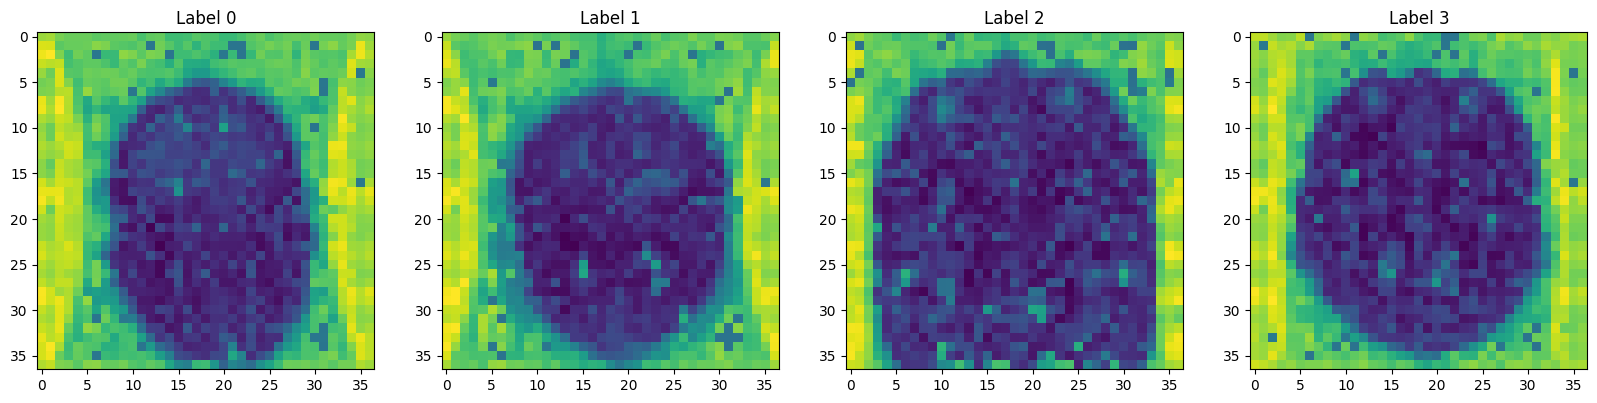

In [8]:
# Min Max Scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())

# 2 - Step PCA (As Mentioned In Paper)
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features[i * patch_h * patch_w : (i + 1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
plt.show()

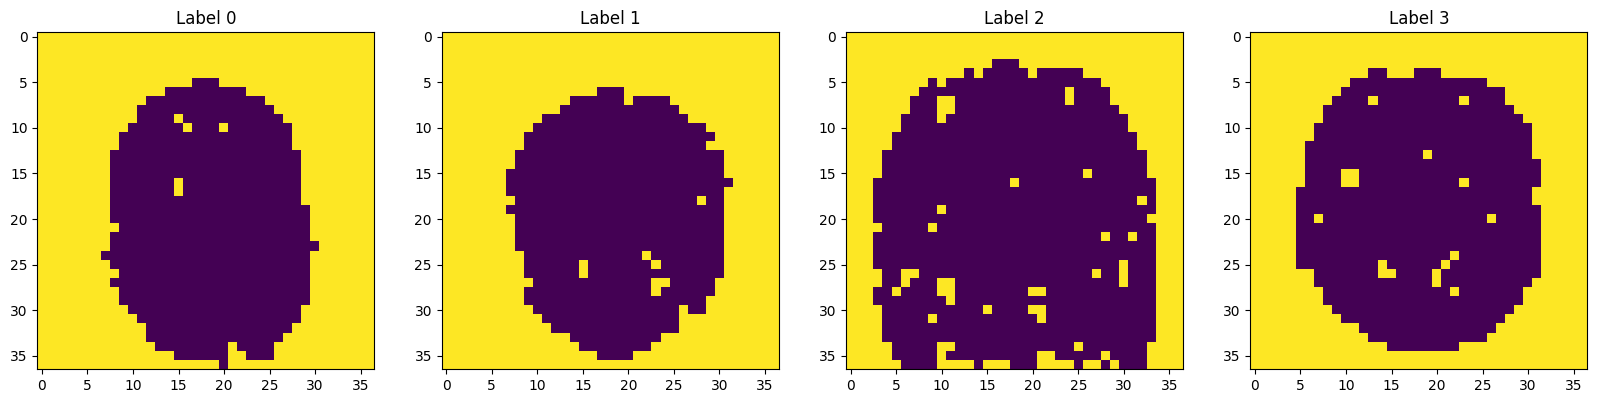

In [9]:
# Segment / Separate Background And Foreground Using The First Component (Take First Component > 0.35, Bitwise Flip)
pca_features_bg = pca_features[:, 0] > 0.35
pca_features_fg = ~pca_features_bg

# Plot PCA Features Background
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i + 1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

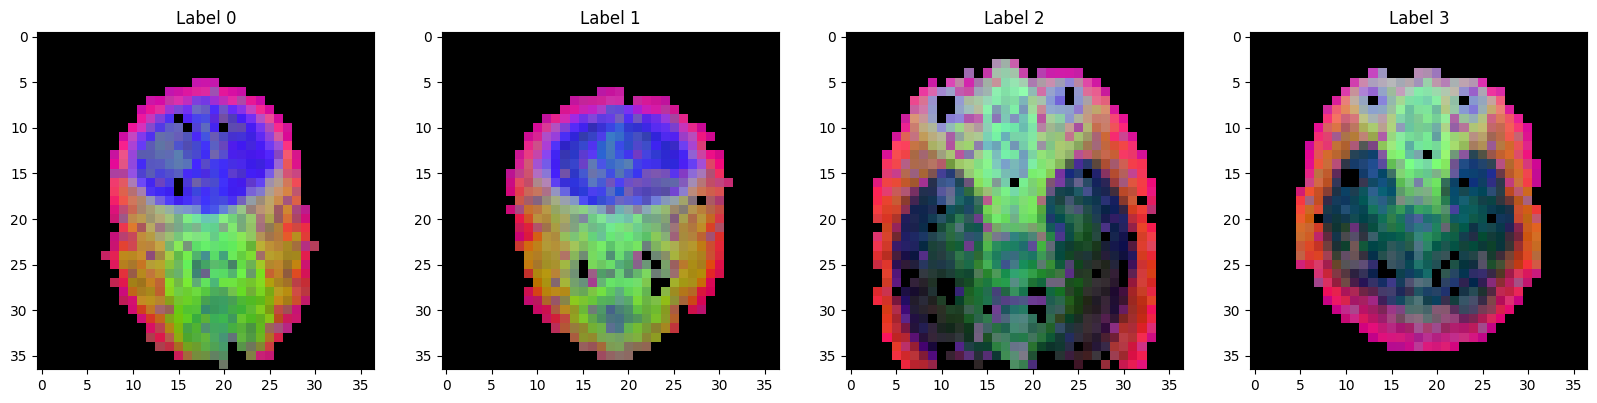

In [10]:
# 2nd PCA For Only Foreground Patches
pca.fit(numpy_array[pca_features_fg]) 
pca_features_left = pca.transform(numpy_array[pca_features_fg])

# Min Max Scale
for i in range(3):
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

# Copying PCA Features
pca_features_rgb = pca_features.copy()

# Black Background (For Better Contrast)
pca_features_rgb[pca_features_bg] = 0

# New Scaled Foreground Features
pca_features_rgb[pca_features_fg] = pca_features_left

# Reshaping To NumPy Image Format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)

# Plot PCA Features RGB
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features_rgb[i])
plt.show()

The most important thing to note about the above graphs is the human interpretability. Unlike the features extracted with PCA and with ResNet50, the features extracted with the DinoV2 model are clearly and reasonably understandable. This could be extremely helpful to doctors and practitioners who are trying to understand the features of a brain tumor, especially since these things can go unchecked quite often until it becomes too late.

### **5.6: Depther Implementation**

In this section, we're going to apply the Depther model in our project. Depther is a depth estimation model that utilizes features from DinoV2 patch to accurately map all aspects of an image without the need for direct supervision. We'll kick off by defining a function that takes in an image as an input and returns the depth map as an output. Here's a brief of how this function works: First, it loads the image and converts it into RGB format. The image then goes through a transformation process before getting passed through the model for feature extraction. These features are then concatenated and reshaped to get the required format. The reshaped features are converted into a numpy array before getting processed through the depth model for depth map generation. 

The depth map, once generated, is converted into a PIL image and returned. Please note that this implementation is largely inspired by the DinoV2 repository. The instructions on how to run the Depther and the Segmenter models are provided in this repository.

In [11]:
# Taken From DinoV2 Repository For Depth Mapping

# CenterPadding Adds Padding To Input Tensor
class CenterPadding(torch.nn.Module):

    # Initialize Multiple
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    # Calculate Padding Needed On Both Sides To Obtain Desired Size
    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    # Apply Padding To Input Tensor
    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = functional.pad(x, pads)
        return output

# Create Depther Model - Based On Configurations Passed Beforehand
# backbone_mode: Pretrained Base Model For Feature Extraction
# backbone_size: Size Of Backbones
# head_type: Type Of Model Head (Classifier, Regressor, Etc.)
def create_depther(cfg, backbone_model, backbone_size, head_type):

    # Extract Train / Test Configurations
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg = train_cfg, test_cfg = test_cfg)

    # Depth Estimation Model Built Using Provided Model Configurations
    # Forward Function Overridden With get_intermediate_layers() - 
    # Gets Outputs From Intermediate Layers Of Backbone During Forward Pass
    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n = cfg.model.backbone.out_indices,
        reshape = True,
        return_class_token = cfg.model.backbone.output_cls_token,
        norm = cfg.model.backbone.final_norm,
    )

    # If Backbone Model Has Patch Size, Register Forward Pre Hook
    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    # Return Depth Estimator Model
    return depther

In [12]:
# Load Config From URL
def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()

# Choose Dataset And Head Type
HEAD_DATASET = "nyu"    # ("nyu", "kitti")
HEAD_TYPE = "dpt"       # ("linear", "linear4", "dpt")

# Load Config From URL
DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

# Load Config From URL, Convert To String, Load Config From String
cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format = ".py")

# Create Depther Model
model = create_depther(
    cfg,
    backbone_model = backbone_model,
    backbone_size = BACKBONE_SIZE,
    head_type = HEAD_TYPE,
)

# Load Checkpoint From URL
load_checkpoint(model, head_checkpoint_url, map_location = "cpu")
model.eval()
model.cuda()

Loads checkpoint by http backend from path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_nyu_dpt_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1536, 192, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1536, 384, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1536, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

The DinoV2 VisionTransformer is at the core of the architecture of DinoV2. Vision Transformers in of themselves are paradigm shifts from traditional convolutional neural networks (CNN). Instead of extracting features through a series of convolutions, they treat images as sequences patches and employ attention mechanisms to obtain crucial insights,. The advantage of using ViT's is they can capture long-range interactions across images, and in this case MRI scans, which traditional CNN's might overlook.The encoder/decoder block has a simultaneous purpose of feature extraction and translating those features into meaningful and interpretable outputs. 

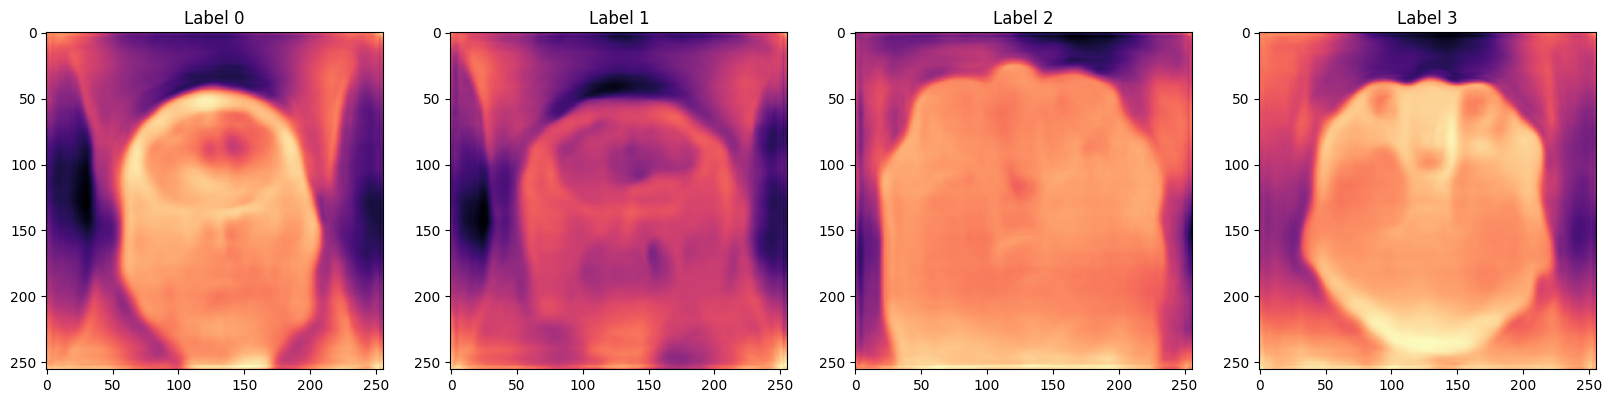

In [13]:
# Creates Composition Of Transformations To Be Applied To Input Data
# transforms.ToTensor() Converts PIL Image / NumPy Array -> Tensor
# transforms.Lambda(lambda x: x.repeat(3, 1, 1)) Repeats Single Channel 3 Times (Mimics RGB)
# transforms.Normalize() Normalizes Tensor With Given Mean / Standard Deviation
# lambda x : 255.0 * x Scales Tensor Values By 255
def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        lambda x : 255.0 * x, 
        transforms.Normalize(
            mean = (123.675, 116.28, 103.53),
            std = (58.395, 57.12, 57.375),
        ),
    ])

# Render Depth Values As An Imag
# Extract Min / Max Values From Depth Data, Normalize It
# Assign Colors To Normalized Values Using Colormap
# Discard Alpha Component Of Each Pixel, Return Result As PIL Image
def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)
    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes = True)
    colors = colors[:, :, :3]
    return Image.fromarray(colors)

# Create Depth Transform Object
transform = make_depth_transform()

# Plot PCA Features RGB
plt.figure(figsize = (20, 6))
for i in range(4):

    # Transform Image, Send To GPU (Make Batch Of One Image, Reduce Memory Usage)
    transformed_image = transform(used_images[i])
    batch = transformed_image.unsqueeze(0).cuda()

    # Inference Mode (No Gradients)
    with torch.inference_mode():
        result = model.whole_inference(batch, img_meta = None, rescale = True)

    # Render Depth Image From Result
    depth_image = render_depth(result.squeeze().cpu())

    # Plot Depth Image
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(depth_image)
plt.show()

The strength of depth maps in highlighting tumors in MRI scans of brains is commendable here. Depth maps essentially translate three-dimensional data into two-dimensional imagery, offering a fresh perspective on spatial relationships within the scan that we could somewhat see in the regular MRI images but are enhanced and brought out here by DinoV2. By providing an elevated visual emphasis on tumors, these maps can be extremely helpful as assistance tools alongside medical personnel for diagnosis.

The differentiation between T1 and T2 weighted images is crucial, as we stated before. As a reminder, T1 and T2 are relaxation times in MRI physics, and their weighted images bring out distinct features in the scan. T1-weighted images tend to highlight fat tissues, making them appear brighter, while T2-weighted images enhance the visibility of fluids. When translated to depth maps, the inherent contrast and intensity differences between T1 and T2 images might appear as variations in the heat maps. This disparity can introduce interpretative challenges, especially when trying to infer tumor consistency, size, and depth. Ensuring a standard protocol for interpretation and possibly using separate models if we had much more data—one each for T1 and T2—can help bridge this gap.

Another challenge is the variability introduced by different imaging angles. MRI scans, by design, capture multiple slices or views of the target region, allowing for a comprehensive visualization. We mentioned this earlier when talking about the orthogonal angles to the brain where they take these images as a standard. However, when these varied angles are rendered into depth maps, inconsistencies can arise. Different angles might emphasize different sections of a tumor or, in some cases, shadow them. Sometimes, eyeballs are enhanced and pop out in horizontal view, but those same areas in coronal views are generally where we search for specific types of tumors. This inconsistency can potentially lead to misinterpretations, especially if certain angles mask, mimic, or distort tumor presence. It's crucial to implement a robust normalization or calibration method that takes into account these variations, ensuring that depth maps, irrespective of the imaging angle, consistently emphasize tumor regions.

### **5.7: DinoV2 Classification Task - Transfer Learning (ViT) + Linear Probe**

In the following blocks, we initially take the step to terminate the kernel so as to free up some VRAM. We then go through the same processes of loading the data and model, just like before. However, the distinguishing factor here is that in this case, we're loading the base model and not the giant one. This adjustment was necessary to ensure that the task could be completed, as my GPU did not have enough capacity to handle the giant model during training (generally, we need double to triple the amount of memory for the model to be finetuned on the data).

In [14]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

In [6]:
# Import Statements

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Other
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

In [8]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "base" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main


In the initial version of the code, we were setting the seed manually. The purpose of setting a seed is to ensure that the random processes yield the same results each time the code is run. This is done for reproducible results, especially in machine learning algorithms which involve several stochastic (random) processes. However, we discovered some issues with the loss function output. Specifically, its results were inconsistent, which is why we removed these lines.

We suspect that the constant seed value was causing these issues, since it wasn't being updated during the training phase. In machine learning, it's common to update the random seed as the model trains, so that each iteration of the training process starts with a different initial state. Please note that we are considering DinoV2 had some issues with the manual seed setting and it could cause some unpredictable results - it is not the general case that setting seed could harm the process, rather, it is specific to our case with DinoV2.

In [9]:
# Initially Was Setting Seed, But Caused Problems With DinoV2
# def set_seed(no):
#     torch.manual_seed(no)
#     random.seed(no)
#     np.random.seed(no)
#     os.environ['PYTHONHASHSEED'] = str()
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True
# set_seed(100)

In this section, we define transformations for both our Training and Testing datasets. The transformations we apply include size adjustment, center cropping, random horizontal flipping, and image normalization. We then use our defined transformations to load images from a directory into datasets and dataloaders, which allow efficient iteration over the data in batches. We define an optimizer which will adjust the parameters of our model during training, and a loss function to compute the error between the model's predictions and the actual values. We also set the number of training epochs and the device for using GPU.

We create a function to train the model. This function iterates over the specified number of epochs, training the model on the Training dataset and evaluating it on the Testing dataset for each epoch. The loss and accuracy for both training and testing are calculated and printed for every epoch.The code block defines the four transformations for both datasets. The transformation includes resizing the images to a 256 x 256 resolution, center cropping them to a 224 x 224 resolution, and normalizing them. For the Training dataset, we also apply a random horizontal flip for data augmentation.

We load our datasets and dataloaders using the transformations and store the size of each dataset. We define our model architecture based on the specifications, including a transformer and classifier layer. Finally, we train our model given these settings. This class defines our model architecture, which includes a transformer layer and a following classifier. The forward method delineates the flow of data through the model.

In [10]:
# Data Augmentation, Normalization For Training
# Note: Similar To Transforms Used Previously, But With Random Horizontal Flip
data_transforms = {
    'Training': transforms.Compose([
        # transforms.RandomResizedCrop(224), # Crops Incorrectly (Not Centered)
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Data From Directory
data_dir = 'Dataset/'
                                                                                     
# image_datasets: Dictionary Of ImageFolder Objects - Generic Data Loader
# dataloaders: Dictionary Of DataLoader Objects - 
# dataset_sizes: Dictionary Of Dataset Sizes (Training, Testing)
# class_names: List Of Class Names (Training)
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = 32, 
                                              shuffle = True,
                                              num_workers = 4) 
                                              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

In [11]:
# Choose Feature Dimension (Depends On Backbone Size)
feat_dims = {"small": 384, "base": 768, "large": 1024, "giant": 1536} 
feat_dim = feat_dims[BACKBONE_SIZE]

# Standard Child Class Of Neural Network Module
# Contains Transformer Model, Classifier Model
# Forward Pass: Transformer -> Classifier
class DinoVisionTransformerClassifier(nn.Module):

    # Initialize Layers (ViT, Sequential Linear Probe)
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = backbone_model
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, 1024),
            nn.Dropout(0.5),
            nn.GELU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.5),
            nn.GELU(),
            nn.Linear(256, 4)
        )
    
    # Layer Format, Forward Pass
    def forward(self, x):
        x = self.transformer(x)
        # x = self.transformer.norm(x) # Not Needed, Don't Learn This
        x = self.classifier(x)        
        return x

In this code, we are implementing a training process for a model utilizing the DinoVisionTransformerClassifier, Cross Entropy Loss, and AdamW optimizer. The model is moved to the device (GPU) for efficient computation. We fix the Vision Transformer's weights to allow training to focus only on the linear classifier. This is accomplished by making the gradients of our model's transformer weights unchangeable.

The model is intended to be trained over five epochs. At each epoch, the current batch of data is passed through the model and loss is calculated using the Cross Entropy criterion. After the loss is calculated, backpropagation is performed to calculate gradients, and the optimizer's step function is used to update the model parameters. The gradients are then set to zero to prevent accumulation.

Statistics for training progress are collected, specifically the running loss. After every 50 mini-batches, we output the average loss over these mini-batches to monitor whether our loss function is moving in the desirable downward direction. Once all epochs are finished, we print a "Training Complete" message. Afterwards, we calculate the accuracy of the finetuned model.

In [12]:
# Instantiate Model, Move To GPU
model = DinoVisionTransformerClassifier()
model = model.to(device)

# Loss Function (Criterion), Optimizer - AdamW
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)

# Don't Learn ViT Weights (Only Learn Classifier Weights)
for i, j in list(model.named_parameters())[:-2]:
    if "transformer" in i:
        j.requires_grad = False

In [13]:
# Set Number Of Epochs, Begin Train Loop
NUM_EPOCHS: int = 5
for epoch in range(NUM_EPOCHS):

    # Set Running Loss Zero
    running_loss = 0.0
    for i, data in enumerate(dataloaders["Training"], 0):

        # Get Inputs; Data Is A List Of [Inputs, Labels]
        inputs, labels = data

        # Zero Parameter Gradients (Ignore This For Now)
        # optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print Statistics (Loss)
        running_loss += loss.item()

        # Print Every 2K Mini-Batches
        if i % 50 == 49:

            # Print Loss (Mean Of Last 50 Mini-Batches)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

# Print Training Complete! :)
print('Training Complete! :)')

[1,    50] loss: 0.834
[1,   100] loss: 0.439
[1,   150] loss: 0.400
[2,    50] loss: 0.358
[2,   100] loss: 0.317
[2,   150] loss: 0.337
[3,    50] loss: 0.314
[3,   100] loss: 0.298
[3,   150] loss: 0.284
[4,    50] loss: 0.260
[4,   100] loss: 0.277
[4,   150] loss: 0.306
[5,    50] loss: 0.231
[5,   100] loss: 0.266
[5,   150] loss: 0.258
Training Complete! :)


In [15]:
# Initialize Correct, Total
correct = 0
total = 0

# Since We're Not Training, We Don't Need To Calculate The Gradients For Our Outputs
with torch.no_grad():
    for data in dataloaders["Testing"]:
        images, labels = data

        # Calculate Outputs By Running Images Through Network
        outputs = model(images.to(device))

        # Class With Highest Energy => Prediction
        _, predicted = torch.max(outputs.data, 1)

        # Total Number Of Labels
        total += labels.size(0)

        # Add Number Of Correct Predictions (Accuracy)
        correct += (predicted.to("cpu") == labels).sum().item()

# Print Accuracy
print(f'Accuracy of the network on the {len(dataloaders["Testing"]) * 32} test images: {100.0 * correct / total} %')

Accuracy of the network on the 1312 test images: 88.40579710144928 %


The accuracy of the model, when fine-tuned with the linear probe, was observed to be about 6% less effective than the ResNet50 model. This outcome was somewhat expected, given that the Vision Transformer from DinoV2 isn't specifically designed for a classification task. Instead, it is developed for extracting human-interpretable features from data, which was evident in the initial analysis sections of DinoV2 models. Though ResNet50 demonstrated higher accuracy in prediction, its feature extraction processes lacked human interpretability.

The steps we went through can be presented as innovative imaging toolkits that could aid a medical practitioner in the prompt diagnosis of patients. Moreover, the final model results could serve as a crucial advisory tool revealing not only the presence of a tumor but also indicating its potential location. This is an advantage that ResNet50 does not offer. Had T1 and T2 labelling been used in the MRI data collection process and if image-captured angles were well-determined, we would likely have been able to design a better model prioritizing human interpretability under these conditions.

In [ ]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

Medium Article Repository: https://github.com/purnasai/Dino_V2

DinoV2 Official GitHub: https://github.com/facebookresearch/dinov2

DinoV2 Official Website: https://dinov2.metademolab.com/

DinoV2 Research Paper: https://arxiv.org/pdf/2304.07193.pdf

```{bibtex}
@misc{oquab2023dinov2,
  title={DINOv2: Learning Robust Visual Features without Supervision},
  author={Oquab, Maxime and Darcet, Timothée and Moutakanni, Theo and Vo, Huy V. and Szafraniec, Marc and Khalidov, Vasil and Fernandez, Pierre and Haziza, Daniel and Massa, Francisco and El-Nouby, Alaaeldin and Howes, Russell and Huang, Po-Yao and Xu, Hu and Sharma, Vasu and Li, Shang-Wen and Galuba, Wojciech and Rabbat, Mike and Assran, Mido and Ballas, Nicolas and Synnaeve, Gabriel and Misra, Ishan and Jegou, Herve and Mairal, Julien and Labatut, Patrick and Joulin, Armand and Bojanowski, Piotr},
  journal={arXiv:2304.07193},
  year={2023}
}
```

```{bibtex}
@inproceedings{optuna_2019,
    title={Optuna: A Next-generation Hyperparameter Optimization Framework},
    author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
    booktitle={Proceedings of the 25th {ACM} {SIGKDD} International Conference on Knowledge Discovery and Data Mining},
    year={2019}
}
```